## Imports

In [1]:
import os
os.environ['R_HOME'] = '/opt/modules/i12g/anaconda/envs/kipoi-veff-analysis/lib/R'

In [226]:
import polars as pl
from pathlib import Path
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import plotnine as pn
# rpy2 dependencies
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.rinterface_lib.embedded import RRuntimeError
import pandas as pd
import statsmodels.api as sm

In [3]:
rbase = importr('base')
rdirichlet_reg = importr('DirichletReg')

## Input

In [4]:
gtex_annotation_path = Path('/s/project/gtex_genetic_diagnosis/v8/sample_annotation.tsv')
gtf_path = Path('/s/project/rep/processed/training_results_v15/gtex_v8_old_dna/gtf_transcripts.parquet')
gtex_transcript_tpm_path = Path('/s/project/rep/processed/training_results_v15/general/gtex_transcript_tpms.zarr/')
genes_path = Path('/data/nasif12/home_if12/tsi/projects/kipoi_veff_analysis/assets/genes.txt')
output_path = Path('/data/nasif12/home_if12/tsi/projects/kipoi_veff_analysis/output/sex_isoforms')

## Load data

In [91]:
def load_transcript_data(gtf_path):
    transcript_ldf = pl.scan_parquet(gtf_path). \
        filter((pl.col('Feature') == 'transcript') & (pl.col('gene_type') == 'protein_coding')). \
        with_columns(gene_id=pl.col('gene_id').str.replace(r"([^\.]+)\..+$", "${1}"),
                     transcript_id=pl.col('transcript_id').str.replace(r"([^\.]+)\..+$", "${1}")). \
        select(['gene_id', 'transcript_id', 'Chromosome']). \
        unique(). \
        rename({'gene_id': 'gene', 'transcript_id': 'transcript', 'Chromosome': 'chrom'}). \
        filter(~pl.col('chrom').is_in(['chrX', 'chrY'])). \
        select(['gene', 'transcript', 'chrom'])
    transcript_df = transcript_ldf.collect().to_pandas().set_index('transcript')
    transcript_xrds = xr.Dataset.from_dataframe(transcript_df).set_coords(("gene", "chrom"))
    genes = transcript_xrds.to_pandas().reset_index().groupby('gene').count().query('transcript > 1').index
    return transcript_xrds.sel(transcript=transcript_xrds['gene'].isin(genes))


def load_individual_data(gtex_annotation_path):
    gtex_individual_df = pl.read_csv(gtex_annotation_path, separator='\t'). \
        select(['INDIVIDUAL_ID', 'SEX']). \
        rename({'INDIVIDUAL_ID': 'individual', 'SEX': 'sex'}). \
        unique()
    return gtex_individual_df.to_pandas().set_index('individual')


def load_expression_data(gtex_transcript_tpm_path, gtex_individual_df):
    expression_xrds = xr.open_zarr(gtex_transcript_tpm_path)
    individuals = ['-'.join(x.split('-')[0:2]) for x in expression_xrds['sample'].data]
    expression_xrds = expression_xrds.assign_coords(dict(individual=('sample', individuals)))
    del expression_xrds['gene']
    expression_xrds = expression_xrds.sel(transcript=~expression_xrds.transcript.str.endswith('_PAR_Y'))
    transcripts = [x.split('.')[0] for x in expression_xrds.transcript.values]
    expression_xrds = expression_xrds.assign_coords(dict(transcript=transcripts))
    individuals = np.intersect1d(expression_xrds['individual'].values, gtex_individual_df.index.values)
    expression_xrds = expression_xrds.sel(sample=expression_xrds['individual'].isin(individuals))
    return expression_xrds.assign_coords(
        sex=('sample', gtex_individual_df.loc[expression_xrds['individual'].data]['sex'].values)
    )


def balanced_sample(data, min_samples_per_sex_tissue=50, seed=42):
    """
    Balance the samples by selecting the same number of samples for each sex in each tissue.
    Every individual should only have one sample per tissue.

    :param data:
    :param seed:
    :return:
    """

    result = []

    # global balance of individuals
    # Ensure one sample per individual per tissue
    data_unique = data.drop_duplicates(subset=['individual', 'tissue'])

    # Split by sex globally
    males_global = data_unique[data_unique['sex'] == 'Male']
    females_global = data_unique[data_unique['sex'] == 'Female']
    
    # Find the minimum count of unique individuals between sexes globally
    min_count_global = min(len(males_global['individual'].unique()), len(females_global['individual'].unique()))

    # Sample globally balanced individuals
    sampled_males = males_global.drop_duplicates(subset='individual').sample(n=min_count_global, random_state=42)
    sampled_females = females_global.drop_duplicates(subset='individual').sample(n=min_count_global, random_state=42)
    
    #Keep all tissues and balance sexes per tissue
    balanced_individuals = pd.concat([sampled_males['individual'], sampled_females['individual']]).unique()
    for tissue, group in data_unique.groupby('tissue'):
        # Get individuals in this tissue and in the balanced individuals set
        tissue_group = group[group['individual'].isin(balanced_individuals)]
        
        # Separate males and females in the tissue
        males_in_tissue = tissue_group[tissue_group['sex'] == 'Male']
        females_in_tissue = tissue_group[tissue_group['sex'] == 'Female']
        
        # Find the minimum number between males and females for balance in the tissue
        min_count_tissue = min(len(males_in_tissue), len(females_in_tissue))
        if min_count_tissue < min_samples_per_sex_tissue:
            continue
        
        # Sample balanced individuals for this tissue
        sampled_males_tissue = males_in_tissue.sample(n=min_count_tissue, random_state=seed)
        sampled_females_tissue = females_in_tissue.sample(n=min_count_tissue, random_state=seed)
        
        # Append the balanced samples for the tissue
        result.append(pd.concat([sampled_males_tissue, sampled_females_tissue]))

    # Concatenate the results for all tissues
    return pd.concat(result)

In [92]:
transcript_xrds = load_transcript_data(gtf_path)
gtex_individual_df = load_individual_data(gtex_annotation_path)
expression_xrds = load_expression_data(gtex_transcript_tpm_path, gtex_individual_df)

In [93]:
transcript_xrds

<xarray.Dataset> Size: 4MB
Dimensions:     (transcript: 145888)
Coordinates:
    gene        (transcript) object 1MB 'ENSG00000136940' ... 'ENSG00000115271'
    chrom       (transcript) object 1MB 'chr9' 'chr3' 'chr16' ... 'chr1' 'chr2'
  * transcript  (transcript) object 1MB 'ENST00000259467' ... 'ENST00000429691'
Data variables:
    *empty*

In [94]:
expression_xrds

<xarray.Dataset> Size: 14GB
Dimensions:     (sample: 17380, transcript: 199166)
Coordinates:
  * sample      (sample) object 139kB 'GTEX-1117F-0226-SM-5GZZ7' ... 'GTEX-ZZ...
    subtissue   (sample) object 139kB ...
    tissue      (sample) object 139kB ...
    individual  (sample) <U10 695kB 'GTEX-1117F' 'GTEX-1117F' ... 'GTEX-ZZPU'
  * transcript  (transcript) <U15 12MB 'ENST00000373020' ... 'ENST00000638628'
    sex         (sample) object 139kB 'Female' 'Female' ... 'Female' 'Female'
Data variables:
    tpm         (transcript, sample) float32 14GB ...

In [95]:
# filter samples
# only keep tissues found in both sexes
tissue_sex_count = expression_xrds[['tissue', 'individual', 'sex']].to_pandas().reset_index()[
    ['tissue', 'sex']].drop_duplicates().groupby('tissue').count()
unisex_tissues = tissue_sex_count.query('sex == 2').index.values
expression_xrds = expression_xrds.sel(sample=expression_xrds['tissue'].isin(unisex_tissues))
# balance the samples
balanced_df = balanced_sample(expression_xrds[['sample']].to_pandas())
expression_xrds = expression_xrds.sel(sample=balanced_df.index.values)
expression_xrds

<xarray.Dataset> Size: 5GB
Dimensions:     (sample: 6702, transcript: 199166)
Coordinates:
  * sample      (sample) object 54kB 'GTEX-132QS-0826-SM-5K7WV' ... 'GTEX-1H1...
    subtissue   (sample) object 54kB 'Adipose - Visceral (Omentum)' ... 'Thyr...
    tissue      (sample) object 54kB 'Adipose Tissue' ... 'Thyroid'
    individual  (sample) <U10 268kB 'GTEX-132QS' 'GTEX-1EN7A' ... 'GTEX-1H1CY'
  * transcript  (transcript) <U15 12MB 'ENST00000373020' ... 'ENST00000638628'
    sex         (sample) object 54kB 'Male' 'Male' 'Male' ... 'Female' 'Female'
Data variables:
    tpm         (transcript, sample) float32 5GB ...

In [436]:
# merge genome annotation and expression data
final_xrds = xr.merge([expression_xrds, transcript_xrds], join='inner')
# genes = np.unique(final_xrds['gene'].data)
# np.savetxt('../../../assets/genes.txt', genes, fmt='%s', delimiter='\n')
final_xrds

<xarray.Dataset> Size: 4GB
Dimensions:     (sample: 6702, transcript: 137988)
Coordinates:
  * sample      (sample) object 54kB 'GTEX-132QS-0826-SM-5K7WV' ... 'GTEX-1H1...
  * transcript  (transcript) object 1MB 'ENST00000371582' ... 'ENST00000622217'
    subtissue   (sample) object 54kB 'Adipose - Visceral (Omentum)' ... 'Thyr...
    tissue      (sample) object 54kB 'Adipose Tissue' ... 'Thyroid'
    individual  (sample) <U10 268kB 'GTEX-132QS' 'GTEX-1EN7A' ... 'GTEX-1H1CY'
    sex         (sample) object 54kB 'Male' 'Male' 'Male' ... 'Female' 'Female'
    gene        (transcript) object 1MB 'ENSG00000000419' ... 'ENSG00000243811'
    chrom       (transcript) object 1MB 'chr20' 'chr20' ... 'chr5' 'chr22'
Data variables:
    tpm         (transcript, sample) float32 4GB ...

In [437]:
gene_index = 1
genes = np.loadtxt(genes_path, dtype=str)
gene = genes[gene_index]
gene = 'ENSG00000144034'

In [438]:
gene_selector = final_xrds['gene'] == gene
final_xrds = final_xrds.sel(transcript=gene_selector)
final_xrds

<xarray.Dataset> Size: 751kB
Dimensions:     (sample: 6702, transcript: 10)
Coordinates:
  * sample      (sample) object 54kB 'GTEX-132QS-0826-SM-5K7WV' ... 'GTEX-1H1...
  * transcript  (transcript) object 80B 'ENST00000272424' ... 'ENST00000497464'
    subtissue   (sample) object 54kB 'Adipose - Visceral (Omentum)' ... 'Thyr...
    tissue      (sample) object 54kB 'Adipose Tissue' ... 'Thyroid'
    individual  (sample) <U10 268kB 'GTEX-132QS' 'GTEX-1EN7A' ... 'GTEX-1H1CY'
    sex         (sample) object 54kB 'Male' 'Male' 'Male' ... 'Female' 'Female'
    gene        (transcript) object 80B 'ENSG00000144034' ... 'ENSG00000144034'
    chrom       (transcript) object 80B 'chr2' 'chr2' 'chr2' ... 'chr2' 'chr2'
Data variables:
    tpm         (transcript, sample) float32 268kB ...

In [439]:
# normalize TPMs, calculate proportion of each transcript
# add 1e10-10 to avoid zeros
final_xrds['tpm'] = final_xrds['tpm'] + 1e-10
total_tpm = final_xrds['tpm'].groupby('sample').sum('transcript')
final_xrds = final_xrds.assign(total_tpm=total_tpm,
                               proportion=final_xrds['tpm'] / total_tpm)
final_xrds

<xarray.Dataset> Size: 1MB
Dimensions:     (sample: 6702, transcript: 10)
Coordinates:
  * sample      (sample) object 54kB 'GTEX-132QS-0826-SM-5K7WV' ... 'GTEX-1H1...
  * transcript  (transcript) object 80B 'ENST00000272424' ... 'ENST00000497464'
    subtissue   (sample) object 54kB 'Adipose - Visceral (Omentum)' ... 'Thyr...
    tissue      (sample) object 54kB 'Adipose Tissue' ... 'Thyroid'
    individual  (sample) <U10 268kB 'GTEX-132QS' 'GTEX-1EN7A' ... 'GTEX-1H1CY'
    sex         (sample) object 54kB 'Male' 'Male' 'Male' ... 'Female' 'Female'
    gene        (transcript) object 80B 'ENSG00000144034' ... 'ENSG00000144034'
    chrom       (transcript) object 80B 'chr2' 'chr2' 'chr2' ... 'chr2' 'chr2'
Data variables:
    tpm         (transcript, sample) float32 268kB 13.95 21.96 ... 0.64 2.96
    total_tpm   (sample) float32 27kB 25.09 35.98 28.13 ... 35.04 32.31 28.04
    proportion  (transcript, sample) float32 268kB 0.556 0.6103 ... 0.1056

In [440]:
final_xrds = final_xrds.sel(transcript=final_xrds['proportion'].median('sample') > 0.1)

In [441]:
final_xrds

<xarray.Dataset> Size: 617kB
Dimensions:     (sample: 6702, transcript: 2)
Coordinates:
  * sample      (sample) object 54kB 'GTEX-132QS-0826-SM-5K7WV' ... 'GTEX-1H1...
  * transcript  (transcript) object 16B 'ENST00000272424' 'ENST00000409716'
    subtissue   (sample) object 54kB 'Adipose - Visceral (Omentum)' ... 'Thyr...
    tissue      (sample) object 54kB 'Adipose Tissue' ... 'Thyroid'
    individual  (sample) <U10 268kB 'GTEX-132QS' 'GTEX-1EN7A' ... 'GTEX-1H1CY'
    sex         (sample) object 54kB 'Male' 'Male' 'Male' ... 'Female' 'Female'
    gene        (transcript) object 16B 'ENSG00000144034' 'ENSG00000144034'
    chrom       (transcript) object 16B 'chr2' 'chr2'
Data variables:
    tpm         (transcript, sample) float32 54kB 13.95 21.96 16.49 ... 3.0 1.97
    total_tpm   (sample) float32 27kB 25.09 35.98 28.13 ... 35.04 32.31 28.04
    proportion  (transcript, sample) float32 54kB 0.556 0.6103 ... 0.07026

In [442]:
# how many individuals per sex?
final_xrds[['sample']].to_pandas()[['individual', 'sex']].drop_duplicates().groupby('sex').count()

,individual
sex,
Female,311
Male,311


In [443]:
# is there max 1 sample per individual-tissue?
np.all(final_xrds[['sample']].to_pandas()[['individual', 'tissue',]].drop_duplicates().reset_index().groupby(['individual', 'tissue']).count() == 1)

np.True_

In [444]:
# are the counts of samples per tissue the same for both sexes?
sample_counts_per_tissue_sex = final_xrds[['sample']].to_pandas().reset_index().groupby(['tissue', 'sex'])['sample'].count().reset_index().pivot(index='tissue', columns='sex', values='sample')
sample_counts_per_tissue_sex

sex,Female,Male
tissue,,
Adipose Tissue,262,262
Adrenal Gland,78,78
Blood,243,243
Blood Vessel,252,252
Brain,108,108
Breast,149,149
Colon,193,193
Esophagus,234,234
Heart,177,177


In [403]:
final_xrds

<xarray.Dataset> Size: 617kB
Dimensions:     (sample: 6702, transcript: 2)
Coordinates:
  * sample      (sample) object 54kB 'GTEX-132QS-0826-SM-5K7WV' ... 'GTEX-1H1...
  * transcript  (transcript) object 16B 'ENST00000372958' 'ENST00000541991'
    subtissue   (sample) object 54kB 'Adipose - Visceral (Omentum)' ... 'Thyr...
    tissue      (sample) object 54kB 'Adipose Tissue' ... 'Thyroid'
    individual  (sample) <U10 268kB 'GTEX-132QS' 'GTEX-1EN7A' ... 'GTEX-1H1CY'
    sex         (sample) object 54kB 'Male' 'Male' 'Male' ... 'Female' 'Female'
    gene        (transcript) object 16B 'ENSG00000048545' 'ENSG00000048545'
    chrom       (transcript) object 16B 'chr6' 'chr6'
Data variables:
    tpm         (transcript, sample) float32 54kB 1e-10 1e-10 ... 1e-10 1e-10
    total_tpm   (sample) float32 27kB 2e-10 2e-10 0.02 0.03 ... 0.02 2e-10 2e-10
    proportion  (transcript, sample) float32 54kB 0.5 0.5 1.0 ... 5e-09 0.5 0.5

## Analysis

In [334]:
def run_dirichlet_reg(df):
    df = df.pivot(index=['sample', 'tissue', 'individual', 'sex'], columns='transcript', values='proportion')
    prop_columns = [f'proportion_{c}' for c in df.columns]
    df.columns = prop_columns
    df = df.reset_index()
    with (ro.default_converter + pandas2ri.converter).context():
        ro.r.assign('df', df)
        ro.r.assign('propColumns', ro.StrVector(prop_columns))

    
    return ro.r(f'''
        # print('Running test')
        total = rowSums(df[, propColumns])
        df[, propColumns] = df[, propColumns] / total
        
        df$proportion = DR_data(df[, propColumns])
        # print('Fitting sex model')
        sexModel = DirichReg(proportion ~ sex, data = df)
        print(summary(sexModel))
        a = coef(sexModel)$proportion_ENST00000371582[['sexMale']]
        a
    ''')

In [288]:
def run_dirichlet_reg(df):
    print('data pivot')
    df = df.pivot(index=['sample', 'tissue', 'individual', 'sex'], columns='transcript', values='proportion')
    prop_columns = [f'proportion_{c}' for c in df.columns]
    df.columns = prop_columns
    df = df.reset_index()
    with (ro.default_converter + pandas2ri.converter).context():
        ro.r.assign('df', df)
        ro.r.assign('propColumns', ro.StrVector(prop_columns))

    
    ro.r(f'''
        print('Running test')
        df$proportion = DR_data(df[, propColumns])
        print('Fitting null model')
        nullModel = DirichReg(proportion ~ sex | 1, data = df, model='alternative')
        print('Fitting sex model')
        sexModel = DirichReg(proportion ~ sex | sex, data = df, model='alternative')
        print('Likelihood-ratio test')
        anovaRes = anova(nullModel, sexModel)
        print(anovaRes)
    ''')

In [430]:
def run_dirichlet_reg(df):
    print('data pivot')
    df = df.pivot(index=['sample', 'tissue', 'individual', 'sex'], columns='transcript', values='proportion')
    prop_columns = [f'proportion_{c}' for c in df.columns]
    df.columns = prop_columns
    df = df.reset_index()
    with (ro.default_converter + pandas2ri.converter).context():
        ro.r.assign('df', df)
        ro.r.assign('propColumns', ro.StrVector(prop_columns))

    
    ro.r(f'''
        print('Running test')
        df$proportion = DR_data(df[, propColumns])
        print('Fitting null model')
        nullModel = DirichReg(proportion ~ tissue * sex | tissue, data = df, model='alternative')
        print('Fitting sex model')
        sexModel = DirichReg(proportion ~ tissue * sex | tissue + sex, data = df, model='alternative')
        print('Likelihood-ratio test')
        anovaRes = anova(nullModel, sexModel)
        print(anovaRes)
    ''')

In [257]:
# extract relevant data
df = final_xrds['proportion'].to_dataframe().reset_index()[
    ['transcript', 'sample', 'tissue', 'sex', 'proportion', 'individual']]
for tissue, df_tissue in df.groupby('tissue'):
    print(tissue)
    try:
        run_dirichlet_reg(df_tissue)
        break
    except RRuntimeError as e:
        print('Did not converge!')
        print('Skipping...')

Adipose Tissue
data pivot
[1] "Running test"


R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  not all rows sum up to 1 => normalization forced
  some entries are 0 or 1 => transformation forced



[1] "Fitting null model"
[1] "Fitting sex model"
[1] "Likelihood-ratio test"

Analysis of Deviance Table

Model 1: DirichReg(formula = proportion ~ sex | 1, data = df, model =
  "alternative")
Model 2: DirichReg(formula = proportion ~ sex | sex, data = df, model =
  "alternative")

        Deviance N. par Difference df  Pr(>Chi)    
Model 1   -17843     11                            
Model 2   -17874     12     31.451  1 2.045e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



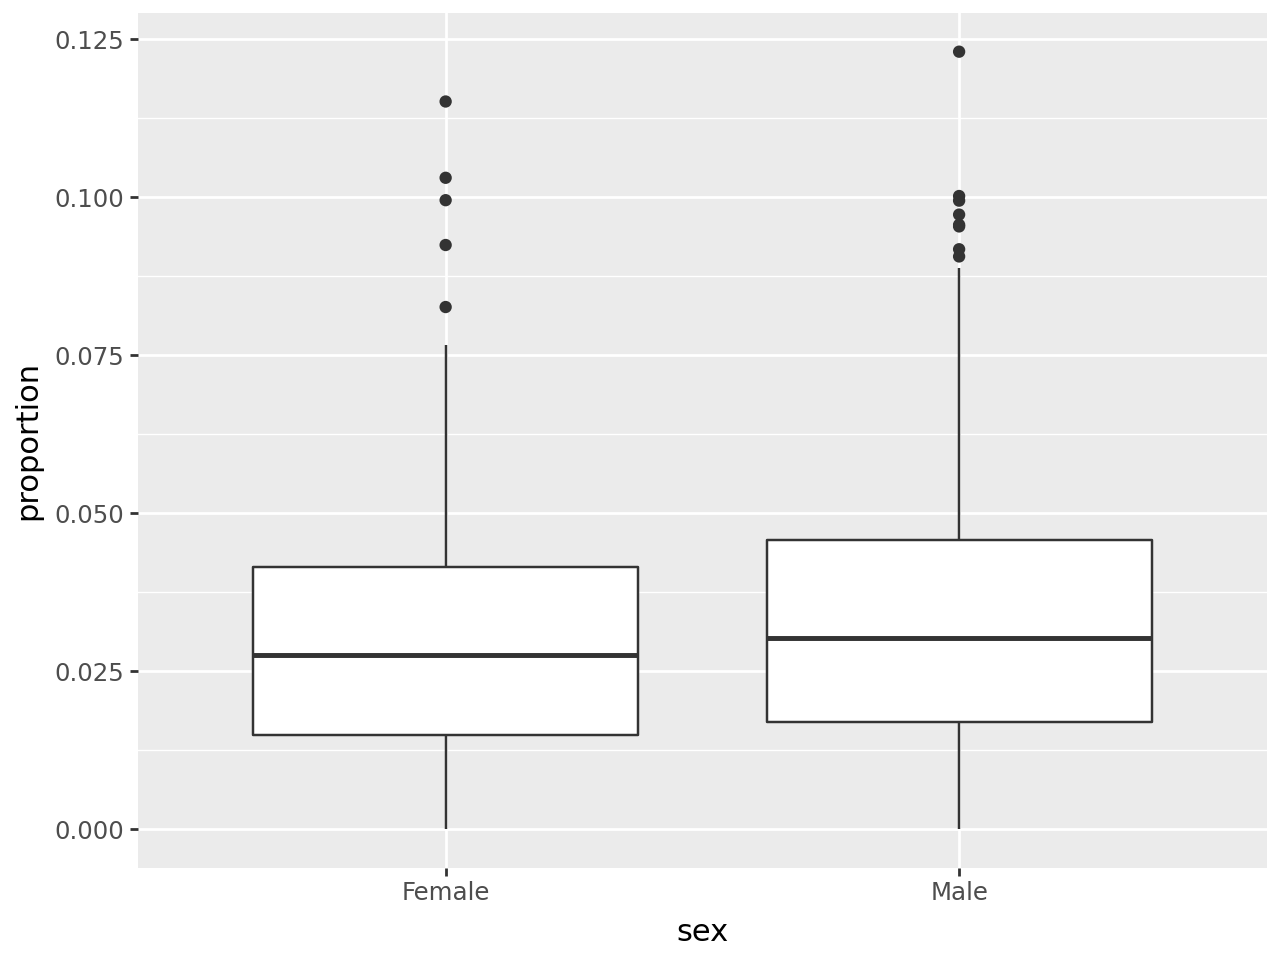

In [172]:
pn.ggplot(random_df_tissue.query('transcript == "ENST00000466152"'), pn.aes(y='proportion', x='sex')) + pn.geom_boxplot()

In [280]:
def random_test(data, tissue):
    # extract relevant data
    random_df = data.copy()
    random_df_tissue = random_df.query('tissue == @tissue')

    # randomize individual sex
    random_individuals_df = random_df_tissue[['individual', 'sex']].drop_duplicates().reset_index(drop=True)
    random_individuals_df['sex'] = np.random.permutation(random_individuals_df['sex'].values)
    random_individuals_df = random_individuals_df.set_index('individual')
    # set new sex
    random_df_tissue['sex'] = random_individuals_df.loc[random_df_tissue['individual'].values]['sex'].values
    try:
        a = run_dirichlet_reg(random_df_tissue)
        return a
    except RRuntimeError as e:
        print('Did not converge!')
        print('Skipping...')
        return None

In [303]:
pd.set_option('display.max_rows', 240)
random_df.groupby(['tissue', 'transcript', 'sex']).median('proportion') > 0.1

proportion
tissue          transcript      sex               
Adipose Tissue  ENST00000371582 Female       False
                                Male         False
                ENST00000371584 Female       False
                                Male         False
                ENST00000371588 Female        True
                                Male          True
                ENST00000413082 Female       False
                                Male         False
                ENST00000466152 Female       False
                                Male         False
                ENST00000494752 Female       False
                                Male         False
Adrenal Gland   ENST00000371582 Female       False
                                Male         False
                ENST00000371584 Female       False
                                Male         False
                ENST00000371588 Female        True
                                Male          True
                ENST00000413082 Female       False
                                Male         False
                ENST00000466152 Female       False
                                Male         False
                ENST00000494752 Female       False
                                Male         False
Blood           ENST00000371582 Female       False
                                Male         False
                ENST00000371584 Female       False
                                Male         False
                ENST00000371588 Female        True
                                Male          True
                ENST00000413082 Female       False
                                Male         False
                ENST00000466152 Female       False
                                Male         False
                ENST00000494752 Female       False
                                Male         False
Blood Vessel    ENST00000371582 Female       False
                                Male         False
                ENST00000371584 Female       False
                                Male         False
                ENST00000371588 Female        True
                                Male          True
                ENST00000413082 Female       False
                                Male         False
                ENST00000466152 Female       False
                                Male         False
                ENST00000494752 Female       False
                                Male         False
Brain           ENST00000371582 Female       False
                                Male         False
                ENST00000371584 Female       False
                                Male         False
                ENST00000371588 Female        True
                                Male          True
                ENST00000413082 Female       False
                                Male         False
                ENST00000466152 Female       False
                                Male         False
                ENST00000494752 Female       False
                                Male         False
Breast          ENST00000371582 Female       False
                                Male         False
                ENST00000371584 Female       False
                                Male         False
                ENST00000371588 Female        True
                                Male          True
                ENST00000413082 Female       False
                                Male         False
                ENST00000466152 Female       False
                                Male         False
                ENST00000494752 Female       False
                                Male         False
Colon           ENST00000371582 Female       False
                                Male         False
                ENST00000371584 Female       False
                                Male         False
                ENST00000371588 Female        True
           

In [286]:
random_df = final_xrds['proportion'].to_dataframe().reset_index()[
        ['transcript', 'sample', 'tissue', 'sex', 'proportion', 'individual']]
random_test(random_df, 'Adipose Tissue')

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.4613  -0.5345  -0.0931   0.4322   3.8227
proportion_ENST00000371584   -1.2878  -0.5523  -0.1145   0.4152   4.0712
proportion_ENST00000371588  -16.1165  -0.3600   0.1987   0.7389   1.8166
proportion_ENST00000413082   -0.5543  -0.5543  -0.5147  -0.5147  60.9567
proportion_ENST00000466152   -1.2495  -0.5841  -0.0810   0.5283   4.0920
proportion_ENST00000494752   -0.5210  -0.5210  -0.5126  -0.5126   3.4579

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.64456    0.05345  12.058   <2e-16 ***
sexMale      0.07171    0.07499   0.956    0.339    
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

0.071711


In [285]:
n_perm = 100
coefs = []
random_df = final_xrds['proportion'].to_dataframe().reset_index()[
        ['transcript', 'sample', 'tissue', 'sex', 'proportion', 'individual']]
for i in range(n_perm):
    a = random_test(random_df, 'Adipose Tissue')
    if a is not None:
        coefs.append(a[0])
    else:
        coefs.append(None)

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.4978  -0.5468  -0.1060   0.4575   4.0298
proportion_ENST00000371584   -1.2066  -0.5693  -0.1076   0.4209   3.4868
proportion_ENST00000371588  -16.1886  -0.3814   0.2456   0.7198   1.8238
proportion_ENST00000413082   -0.5427  -0.5427  -0.5240  -0.5199  60.4454
proportion_ENST00000466152   -1.2582  -0.5773  -0.0719   0.4740   3.9718
proportion_ENST00000494752   -0.5222  -0.5222  -0.5113  -0.5113   4.6097

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.59519    0.05358   11.11   <2e-16 ***
sexMale      0.16654    0.07501    2.22   0.0264 *  
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5238  -0.5413  -0.1385   0.4402   5.1272
proportion_ENST00000371584   -1.2966  -0.5614  -0.1143   0.4066   3.3968
proportion_ENST00000371588  -16.2794  -0.4143   0.2248   0.6968   1.8957
proportion_ENST00000413082   -0.5416  -0.5416  -0.5249  -0.5214  58.8637
proportion_ENST00000466152   -1.2902  -0.5749  -0.0808   0.4618   3.9439
proportion_ENST00000494752   -0.5246  -0.5246  -0.5090  -0.5090   3.4207

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.56160    0.05386  10.427  < 2e-16 ***
sexMale      0.23445    0.07502   3.125  0.00178 ** 
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5269  -0.5430  -0.1381   0.4601   4.0092
proportion_ENST00000371584   -1.2961  -0.5492  -0.1151   0.4371   4.1188
proportion_ENST00000371588  -16.0151  -0.4495   0.2099   0.7407   1.8529
proportion_ENST00000413082   -0.5436  -0.5436  -0.5237  -0.5210  59.2627
proportion_ENST00000466152   -1.2075  -0.5666  -0.0807   0.5112   3.4876
proportion_ENST00000494752   -0.5247  -0.5247  -0.5094  -0.5094   4.7436

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.56692    0.05375  10.548  < 2e-16 ***
sexMale      0.23356    0.07497   3.115  0.00184 ** 
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced

R[write to console]: Error in summary.DirichletRegModel(sexModel) : 
Optimization did not converge in 75 + 2 iterations and exited with code 8

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to consol

Did not converge!
Skipping...

Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5450  -0.5392  -0.1386   0.4583   4.8541
proportion_ENST00000371584   -1.2686  -0.5557  -0.1161   0.4214   3.4583
proportion_ENST00000371588  -16.5090  -0.4204   0.2301   0.6949   1.9011
proportion_ENST00000413082   -0.5391  -0.5391  -0.5268  -0.5227  59.8014
proportion_ENST00000466152   -1.2472  -0.5780  -0.0762   0.4991   3.1752
proportion_ENST00000494752   -0.5268  -0.5268  -0.5068  -0.5068   4.5529

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.53342    0.05392   9.892  < 2e-16 ***
sexMale      0.28669    0.07504   3.820 0.000133 ***
------------------------------------------------------------------
Beta-Coefficients f

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5712  -0.5382  -0.1239   0.4689   3.9915
proportion_ENST00000371584   -1.2537  -0.5586  -0.1169   0.4831   3.0891
proportion_ENST00000371588  -15.9021  -0.3536   0.2169   0.7270   1.9027
proportion_ENST00000413082   -0.5406  -0.5406  -0.5265  -0.5226  57.1472
proportion_ENST00000466152   -1.3411  -0.5771  -0.0763   0.4751   3.2649
proportion_ENST00000494752   -0.5279  -0.5279  -0.5069  -0.5069   3.3350

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.51893    0.05405   9.601  < 2e-16 ***
sexMale      0.33847    0.07495   4.516 6.31e-06 ***
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5392  -0.5370  -0.1414   0.4427   3.9119
proportion_ENST00000371584   -1.2717  -0.5539  -0.1089   0.4707   4.3889
proportion_ENST00000371588  -15.8636  -0.3601   0.2253   0.7268   1.8755
proportion_ENST00000413082   -0.5474  -0.5474  -0.5205  -0.5205  57.9849
proportion_ENST00000466152   -1.3106  -0.5802  -0.0727   0.4563   4.0268
proportion_ENST00000494752   -0.5210  -0.5210  -0.5127  -0.5127   3.3043

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.54995    0.05391  10.202  < 2e-16 ***
sexMale      0.26773    0.07498   3.571 0.000356 ***
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.4700  -0.5270  -0.1334   0.4529   4.0517
proportion_ENST00000371584   -1.2473  -0.5464  -0.1206   0.4239   4.0186
proportion_ENST00000371588  -16.5679  -0.3953   0.1991   0.7112   1.8395
proportion_ENST00000413082   -0.5355  -0.5355  -0.5299  -0.5257  60.9987
proportion_ENST00000466152   -1.2408  -0.5800  -0.0768   0.4865   3.5599
proportion_ENST00000494752   -0.5214  -0.5214  -0.5115  -0.5115   4.4569

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.62161    0.05347  11.626   <2e-16 ***
sexMale      0.10213    0.07506   1.361    0.174    
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5493  -0.5291  -0.1381   0.4512   4.9636
proportion_ENST00000371584   -1.2901  -0.5451  -0.1168   0.4187   3.4598
proportion_ENST00000371588  -16.2963  -0.4224   0.2281   0.6933   1.9012
proportion_ENST00000413082   -0.5486  -0.5486  -0.5189  -0.5148  59.8141
proportion_ENST00000466152   -1.2422  -0.5831  -0.0773   0.4928   4.1456
proportion_ENST00000494752   -0.5186  -0.5186  -0.5144  -0.5144   4.7361

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.53218    0.05394   9.866  < 2e-16 ***
sexMale      0.29481    0.07502   3.930  8.5e-05 ***
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5801  -0.5351  -0.1382   0.4431   3.9959
proportion_ENST00000371584   -1.2775  -0.5480  -0.1212   0.5026   3.5059
proportion_ENST00000371588  -15.7547  -0.4435   0.2290   0.7058   1.7596
proportion_ENST00000413082   -0.5481  -0.5481  -0.5199  -0.5199  57.4096
proportion_ENST00000466152   -1.2809  -0.5792  -0.0690   0.4771   4.2455
proportion_ENST00000494752   -0.5295  -0.5295  -0.5054  -0.5054   3.3200

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.86822    0.05187  16.739  < 2e-16 ***
sexMale     -0.36275    0.07496  -4.839  1.3e-06 ***
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5698  -0.5302  -0.1351   0.4477   5.2901
proportion_ENST00000371584   -1.3098  -0.5398  -0.1273   0.4248   4.3344
proportion_ENST00000371588  -15.8382  -0.3996   0.2047   0.7023   1.7310
proportion_ENST00000413082   -0.5451  -0.5451  -0.5227  -0.5202  56.7899
proportion_ENST00000466152   -1.3372  -0.5900  -0.0911   0.4662   3.1953
proportion_ENST00000494752   -0.5203  -0.5203  -0.5135  -0.5135   3.3719

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.51961    0.05409   9.607  < 2e-16 ***
sexMale      0.33710    0.07496   4.497 6.88e-06 ***
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5583  -0.5361  -0.1349   0.4592   5.1063
proportion_ENST00000371584   -1.2539  -0.5616  -0.0992   0.4599   4.4149
proportion_ENST00000371588  -15.9921  -0.4084   0.2276   0.7142   1.8809
proportion_ENST00000413082   -0.5357  -0.5357  -0.5305  -0.5266  57.4511
proportion_ENST00000466152   -1.2997  -0.5807  -0.0878   0.4651   4.0172
proportion_ENST00000494752   -0.5240  -0.5240  -0.5098  -0.5098   3.3587

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.84008    0.05207  16.132  < 2e-16 ***
sexMale     -0.31323    0.07499  -4.177 2.95e-05 ***
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5578  -0.5316  -0.1383   0.4580   4.0142
proportion_ENST00000371584   -1.3094  -0.5516  -0.1195   0.4335   4.1778
proportion_ENST00000371588  -15.8968  -0.3618   0.2127   0.7246   1.8845
proportion_ENST00000413082   -0.5360  -0.5360  -0.5306  -0.5264  57.4324
proportion_ENST00000466152   -1.2301  -0.5636  -0.0611   0.4992   3.3289
proportion_ENST00000494752   -0.5285  -0.5285  -0.5063  -0.5063   3.3857

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.84003    0.05207  16.134  < 2e-16 ***
sexMale     -0.30753    0.07496  -4.103 4.09e-05 ***
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced

R[write to console]: Error in summary.DirichletRegModel(sexModel) : 
Optimization did not converge in 94 + 2 iterations and exited with code 8

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to consol

Did not converge!
Skipping...

Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5770  -0.5224  -0.1367   0.4503   4.0538
proportion_ENST00000371584   -1.3093  -0.5430  -0.1164   0.4066   4.1917
proportion_ENST00000371588  -16.0347  -0.4335   0.2719   0.7025   1.9158
proportion_ENST00000413082   -0.5333  -0.5333  -0.5327  -0.5273  56.7023
proportion_ENST00000466152   -1.2818  -0.5797  -0.0657   0.4793   3.8079
proportion_ENST00000494752   -0.5296  -0.5296  -0.5051  -0.5051   3.3641

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.50654    0.05409   9.364  < 2e-16 ***
sexMale      0.35684    0.07498   4.759 1.95e-06 ***
------------------------------------------------------------------
Beta-Coefficients f

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.6280  -0.5313  -0.1442   0.4531   3.9148
proportion_ENST00000371584   -1.3571  -0.5746  -0.1266   0.4229   3.4384
proportion_ENST00000371588  -15.5948  -0.3886   0.2261   0.7080   1.9998
proportion_ENST00000413082   -0.5464  -0.5464  -0.5222  -0.5198  55.0554
proportion_ENST00000466152   -1.3452  -0.5749  -0.0940   0.5023   3.2150
proportion_ENST00000494752   -0.5326  -0.5326  -0.5037  -0.5037   5.1952

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.92917    0.05147  18.054  < 2e-16 ***
sexMale     -0.46296    0.07489  -6.182 6.34e-10 ***
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.4760  -0.5506  -0.1323   0.4260   3.8287
proportion_ENST00000371584   -1.2729  -0.5424  -0.1343   0.4101   4.1952
proportion_ENST00000371588  -16.0558  -0.3692   0.2219   0.7242   1.8537
proportion_ENST00000413082   -0.5567  -0.5567  -0.5127  -0.5127  60.4957
proportion_ENST00000466152   -1.2782  -0.5912  -0.0903   0.4843   4.0027
proportion_ENST00000494752   -0.5255  -0.5255  -0.5085  -0.5085   3.4468

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.73590    0.05247  14.025   <2e-16 ***
sexMale     -0.11191    0.07500  -1.492    0.136    
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5324  -0.5295  -0.1517   0.4484   3.9482
proportion_ENST00000371584   -1.3125  -0.5520  -0.1157   0.4372   4.1074
proportion_ENST00000371588  -16.0259  -0.3734   0.2241   0.7143   1.9013
proportion_ENST00000413082   -0.5411  -0.5411  -0.5255  -0.5240  58.0228
proportion_ENST00000466152   -1.2658  -0.5774  -0.0725   0.5089   4.1668
proportion_ENST00000494752   -0.5328  -0.5328  -0.5024  -0.5024   4.7291

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.80820    0.05214  15.499  < 2e-16 ***
sexMale     -0.25303    0.07499  -3.374 0.000741 ***
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced

R[write to console]: Error in summary.DirichletRegModel(sexModel) : 
Optimization did not converge in 102 + 2 iterations and exited with code 8

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to conso

Did not converge!
Skipping...

Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5010  -0.5374  -0.1289   0.4768   5.1467
proportion_ENST00000371584   -1.2725  -0.5508  -0.1279   0.4368   4.1188
proportion_ENST00000371588  -16.1723  -0.3975   0.2260   0.7147   1.7965
proportion_ENST00000413082   -0.5475  -0.5475  -0.5197  -0.5197  60.1484
proportion_ENST00000466152   -1.2379  -0.5723  -0.0945   0.5045   4.1231
proportion_ENST00000494752   -0.5234  -0.5234  -0.5101  -0.5101   4.6470

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.58829    0.05368  10.959   <2e-16 ***
sexMale      0.17825    0.07502   2.376   0.0175 *  
------------------------------------------------------------------
Beta-Coefficients f

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5584  -0.5418  -0.1436   0.4844   4.0856
proportion_ENST00000371584   -1.3127  -0.5409  -0.1208   0.4249   3.4181
proportion_ENST00000371588  -16.1500  -0.4308   0.2195   0.7177   1.8893
proportion_ENST00000413082   -0.5456  -0.5456  -0.5217  -0.5200  58.8875
proportion_ENST00000466152   -1.2371  -0.5738  -0.1040   0.5174   3.9186
proportion_ENST00000494752   -0.5218  -0.5218  -0.5118  -0.5118   4.8000

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.83939    0.05206  16.124  < 2e-16 ***
sexMale     -0.31250    0.07499  -4.167 3.08e-05 ***
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.6230  -0.5486  -0.1476   0.4421   4.2357
proportion_ENST00000371584   -1.2330  -0.5610  -0.1134   0.4462   4.6025
proportion_ENST00000371588  -16.0291  -0.3969   0.2240   0.7263   1.9006
proportion_ENST00000413082   -0.5402  -0.5402  -0.5262  -0.5259  56.5620
proportion_ENST00000466152   -1.2889  -0.5742  -0.0549   0.4977   4.1415
proportion_ENST00000494752   -0.5260  -0.5260  -0.5087  -0.5087   4.8812

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.91790    0.05179  17.724  < 2e-16 ***
sexMale     -0.45021    0.07494  -6.008 1.88e-09 ***
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5986  -0.5475  -0.1404   0.4535   4.9020
proportion_ENST00000371584   -1.2748  -0.5422  -0.1090   0.4234   4.2977
proportion_ENST00000371588  -16.1058  -0.3966   0.2464   0.7139   1.8943
proportion_ENST00000413082   -0.5348  -0.5348  -0.5315  -0.5268  57.5845
proportion_ENST00000466152   -1.2511  -0.5873  -0.0576   0.4987   3.3541
proportion_ENST00000494752   -0.5263  -0.5263  -0.5080  -0.5080   3.3886

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.48462    0.05413   8.953  < 2e-16 ***
sexMale      0.40354    0.07498   5.382 7.36e-08 ***
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5568  -0.5367  -0.1430   0.4705   5.1435
proportion_ENST00000371584   -1.2729  -0.5548  -0.1210   0.4423   4.3435
proportion_ENST00000371588  -15.9270  -0.3669   0.2158   0.7175   1.8984
proportion_ENST00000413082   -0.5392  -0.5392  -0.5272  -0.5233  57.4711
proportion_ENST00000466152   -1.2850  -0.5821  -0.0779   0.5020   4.1124
proportion_ENST00000494752   -0.5263  -0.5263  -0.5078  -0.5078   3.3541

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.52746    0.05398   9.771  < 2e-16 ***
sexMale      0.31117    0.07499   4.149 3.33e-05 ***
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5418  -0.5338  -0.1311   0.4677   4.0038
proportion_ENST00000371584   -1.2470  -0.5596  -0.1054   0.4578   3.7669
proportion_ENST00000371588  -16.0641  -0.3778   0.2267   0.7138   1.7651
proportion_ENST00000413082   -0.5385  -0.5385  -0.5280  -0.5251  58.0493
proportion_ENST00000466152   -1.3173  -0.5722  -0.0898   0.4774   3.5699
proportion_ENST00000494752   -0.5242  -0.5242  -0.5097  -0.5097   3.3824

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.54609    0.05389  10.134  < 2e-16 ***
sexMale      0.27343    0.07499   3.646 0.000266 ***
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5726  -0.5386  -0.1387   0.4559   4.1438
proportion_ENST00000371584   -1.2798  -0.5456  -0.1049   0.4206   3.3377
proportion_ENST00000371588  -16.0402  -0.3908   0.2218   0.7192   1.7851
proportion_ENST00000413082   -0.5408  -0.5408  -0.5262  -0.5244  58.6203
proportion_ENST00000466152   -1.2164  -0.5696  -0.0981   0.5105   3.3483
proportion_ENST00000494752   -0.5201  -0.5201  -0.5135  -0.5135   4.8256

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.51495    0.05396   9.543  < 2e-16 ***
sexMale      0.34175    0.07497   4.558 5.15e-06 ***
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5761  -0.5283  -0.1387   0.4559   3.9132
proportion_ENST00000371584   -1.3689  -0.5551  -0.1331   0.4272   4.0925
proportion_ENST00000371588  -15.9016  -0.3918   0.2039   0.7166   1.9755
proportion_ENST00000413082   -0.5538  -0.5538  -0.5158  -0.5119  57.3079
proportion_ENST00000466152   -1.3119  -0.5920  -0.0613   0.5154   4.1935
proportion_ENST00000494752   -0.5276  -0.5276  -0.5073  -0.5073   3.2705

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.51564    0.05418   9.518  < 2e-16 ***
sexMale      0.34925    0.07494   4.661 3.15e-06 ***
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5093  -0.5297  -0.1155   0.4743   3.8666
proportion_ENST00000371584   -1.3037  -0.5394  -0.1195   0.4183   3.3573
proportion_ENST00000371588  -15.9680  -0.3763   0.2265   0.7267   1.8842
proportion_ENST00000413082   -0.5438  -0.5438  -0.5234  -0.5207  58.3659
proportion_ENST00000466152   -1.2803  -0.5787  -0.0710   0.4652   4.0946
proportion_ENST00000494752   -0.5231  -0.5231  -0.5107  -0.5107   3.3641

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.58381    0.05375  10.861  < 2e-16 ***
sexMale      0.19569    0.07499   2.609  0.00907 ** 
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.4940  -0.5348  -0.1523   0.4352   3.8890
proportion_ENST00000371584   -1.2627  -0.5529  -0.1167   0.4547   4.2560
proportion_ENST00000371588  -15.9810  -0.4024   0.2432   0.7429   1.8429
proportion_ENST00000413082   -0.5385  -0.5385  -0.5279  -0.5251  58.7411
proportion_ENST00000466152   -1.2660  -0.5783  -0.0801   0.5009   4.0714
proportion_ENST00000494752   -0.5187  -0.5187  -0.5146  -0.5146   4.7770

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.75886    0.05247  14.462   <2e-16 ***
sexMale     -0.15769    0.07500  -2.102   0.0355 *  
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5076  -0.5373  -0.1259   0.4318   3.9014
proportion_ENST00000371584   -1.2551  -0.5501  -0.1363   0.4504   4.3372
proportion_ENST00000371588  -15.9653  -0.4165   0.2411   0.7307   1.8618
proportion_ENST00000413082   -0.5495  -0.5495  -0.5184  -0.5143  59.2632
proportion_ENST00000466152   -1.2841  -0.5831  -0.0666   0.5071   4.0244
proportion_ENST00000494752   -0.5273  -0.5273  -0.5069  -0.5069   3.4188

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.58397    0.05374  10.866   <2e-16 ***
sexMale      0.19261    0.07500   2.568   0.0102 *  
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5386  -0.5354  -0.1267   0.4212   4.0169
proportion_ENST00000371584   -1.3078  -0.5508  -0.1143   0.4126   4.0939
proportion_ENST00000371588  -16.0344  -0.3649   0.2261   0.7244   1.8777
proportion_ENST00000413082   -0.5387  -0.5387  -0.5279  -0.5239  58.3747
proportion_ENST00000466152   -1.2299  -0.5646  -0.0840   0.5531   4.3117
proportion_ENST00000494752   -0.5171  -0.5171  -0.5161  -0.5161   4.8600

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.55145    0.05381  10.248  < 2e-16 ***
sexMale      0.26385    0.07498   3.519 0.000434 ***
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.4988  -0.5420  -0.1343   0.4679   3.8801
proportion_ENST00000371584   -1.2304  -0.5701  -0.1354   0.4820   3.5554
proportion_ENST00000371588  -16.0638  -0.3560   0.2203   0.7275   1.8557
proportion_ENST00000413082   -0.5501  -0.5501  -0.5185  -0.5144  59.7205
proportion_ENST00000466152   -1.3382  -0.5748  -0.0763   0.4883   3.4636
proportion_ENST00000494752   -0.5255  -0.5255  -0.5089  -0.5089   3.4335

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.76584    0.05234  14.631   <2e-16 ***
sexMale     -0.16208    0.07496  -2.162   0.0306 *  
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5138  -0.5355  -0.1468   0.4470   4.0657
proportion_ENST00000371584   -1.2546  -0.5388  -0.1010   0.4315   4.1570
proportion_ENST00000371588  -16.3667  -0.3943   0.2263   0.7060   1.7714
proportion_ENST00000413082   -0.5440  -0.5440  -0.5225  -0.5204  60.0777
proportion_ENST00000466152   -1.2692  -0.5763  -0.0880   0.4621   3.2457
proportion_ENST00000494752   -0.5252  -0.5252  -0.5082  -0.5082   3.4903

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.78176    0.05234  14.936  < 2e-16 ***
sexMale     -0.21242    0.07504  -2.831  0.00464 ** 
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5447  -0.5381  -0.1291   0.4568   3.8914
proportion_ENST00000371584   -1.2887  -0.5470  -0.1106   0.4642   4.3547
proportion_ENST00000371588  -15.7084  -0.3452   0.2450   0.7167   1.8636
proportion_ENST00000413082   -0.5439  -0.5439  -0.5234  -0.5230  57.2930
proportion_ENST00000466152   -1.2748  -0.5812  -0.0827   0.5207   3.1926
proportion_ENST00000494752   -0.5294  -0.5294  -0.5055  -0.5055   3.3349

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.82514    0.05207  15.846  < 2e-16 ***
sexMale     -0.28019    0.07497  -3.738 0.000186 ***
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5910  -0.5432  -0.1332   0.4344   3.9878
proportion_ENST00000371584   -1.2608  -0.5548  -0.1341   0.4988   4.6170
proportion_ENST00000371588  -15.8588  -0.4037   0.2468   0.7119   1.9341
proportion_ENST00000413082   -0.5435  -0.5435  -0.5244  -0.5235  56.7801
proportion_ENST00000466152   -1.3685  -0.5648  -0.0748   0.4848   3.9156
proportion_ENST00000494752   -0.5320  -0.5320  -0.5039  -0.5039   3.3200

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.50261    0.05417   9.279  < 2e-16 ***
sexMale      0.37986    0.07492   5.070 3.97e-07 ***
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5507  -0.5418  -0.1380   0.4724   4.8791
proportion_ENST00000371584   -1.2437  -0.5463  -0.0978   0.4155   4.2401
proportion_ENST00000371588  -16.2934  -0.4210   0.2305   0.7164   1.8676
proportion_ENST00000413082   -0.5439  -0.5439  -0.5228  -0.5206  60.0819
proportion_ENST00000466152   -1.2247  -0.5770  -0.0768   0.4977   3.2931
proportion_ENST00000494752   -0.5256  -0.5256  -0.5081  -0.5081   4.6049

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.82764    0.05218  15.861  < 2e-16 ***
sexMale     -0.29655    0.07502  -3.953 7.72e-05 ***
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced

R[write to console]: Error in summary.DirichletRegModel(sexModel) : 
Optimization did not converge in 76 + 2 iterations and exited with code 8

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to consol

Did not converge!
Skipping...

Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5973  -0.5453  -0.1289   0.4401   5.2670
proportion_ENST00000371584   -1.2512  -0.5240  -0.1278   0.4631   3.7592
proportion_ENST00000371588  -15.5407  -0.3698   0.2225   0.7174   1.7712
proportion_ENST00000413082   -0.5389  -0.5389  -0.5285  -0.5247  55.9196
proportion_ENST00000466152   -1.3173  -0.5700  -0.0796   0.5135   3.8621
proportion_ENST00000494752   -0.5286  -0.5286  -0.5068  -0.5068   5.0642

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.89082    0.05179  17.200  < 2e-16 ***
sexMale     -0.39342    0.07491  -5.252  1.5e-07 ***
------------------------------------------------------------------
Beta-Coefficients f

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced

R[write to console]: Error in summary.DirichletRegModel(sexModel) : 
Optimization did not converge in 144 + 2 iterations and exited with code 8

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to conso

Did not converge!
Skipping...

Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5072  -0.5507  -0.1194   0.4547   5.1011
proportion_ENST00000371584   -1.2662  -0.5404  -0.1056   0.4307   3.3446
proportion_ENST00000371588  -16.2999  -0.4312   0.2081   0.7098   1.8802
proportion_ENST00000413082   -0.5438  -0.5438  -0.5228  -0.5205  59.7796
proportion_ENST00000466152   -1.2749  -0.5836  -0.0858   0.4498   3.2429
proportion_ENST00000494752   -0.5230  -0.5230  -0.5102  -0.5102   3.4565

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.57859    0.05374  10.766  < 2e-16 ***
sexMale      0.19550    0.07504   2.605  0.00918 ** 
------------------------------------------------------------------
Beta-Coefficients f

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.4961  -0.5262  -0.1207   0.4497   5.0225
proportion_ENST00000371584   -1.2395  -0.5502  -0.1157   0.4180   4.1588
proportion_ENST00000371588  -16.3082  -0.3483   0.2245   0.7299   1.8253
proportion_ENST00000413082   -0.5431  -0.5431  -0.5233  -0.5231  60.9306
proportion_ENST00000466152   -1.2148  -0.5709  -0.0760   0.5072   3.1270
proportion_ENST00000494752   -0.5221  -0.5221  -0.5111  -0.5111   4.5447

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.59327    0.05359  11.071   <2e-16 ***
sexMale      0.16523    0.07503   2.202   0.0277 *  
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.6294  -0.5271  -0.1255   0.4802   3.9307
proportion_ENST00000371584   -1.3116  -0.5479  -0.1178   0.4251   3.9165
proportion_ENST00000371588  -15.5147  -0.4238   0.2202   0.7146   1.9543
proportion_ENST00000413082   -0.5347  -0.5347  -0.5324  -0.5287  54.2533
proportion_ENST00000466152   -1.3571  -0.5889  -0.0828   0.4801   4.1924
proportion_ENST00000494752   -0.5271  -0.5271  -0.5082  -0.5082   3.1703

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.93064    0.05155  18.053  < 2e-16 ***
sexMale     -0.46376    0.07489  -6.193 5.92e-10 ***
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.6266  -0.5408  -0.1412   0.4373   3.9640
proportion_ENST00000371584   -1.3411  -0.5476  -0.1239   0.4219   3.7249
proportion_ENST00000371588  -15.7198  -0.4329   0.1927   0.7141   1.9993
proportion_ENST00000413082   -0.5383  -0.5383  -0.5290  -0.5254  54.9084
proportion_ENST00000466152   -1.3538  -0.5897  -0.0916   0.5068   4.1477
proportion_ENST00000494752   -0.5281  -0.5281  -0.5072  -0.5072   5.1758

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.46672    0.05436   8.585  < 2e-16 ***
sexMale      0.45981    0.07491   6.138 8.34e-10 ***
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.6222  -0.5341  -0.1346   0.4285   3.9119
proportion_ENST00000371584   -1.3321  -0.5542  -0.1101   0.4519   3.1594
proportion_ENST00000371588  -15.5115  -0.3993   0.2147   0.7181   1.9485
proportion_ENST00000413082   -0.5416  -0.5416  -0.5262  -0.5241  54.8076
proportion_ENST00000466152   -1.3346  -0.5841  -0.0736   0.5157   3.9228
proportion_ENST00000494752   -0.5281  -0.5281  -0.5072  -0.5072   5.2189

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.47137    0.05433   8.676  < 2e-16 ***
sexMale      0.45064    0.07490   6.016 1.78e-09 ***
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5060  -0.5300  -0.1247   0.4576   5.1490
proportion_ENST00000371584   -1.2615  -0.5444  -0.1156   0.4297   3.5677
proportion_ENST00000371588  -16.2041  -0.4166   0.2402   0.7164   1.7792
proportion_ENST00000413082   -0.5420  -0.5420  -0.5245  -0.5212  59.3596
proportion_ENST00000466152   -1.2775  -0.5745  -0.0762   0.4844   3.9513
proportion_ENST00000494752   -0.5258  -0.5258  -0.5079  -0.5079   3.4594

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.77305    0.05237  14.763   <2e-16 ***
sexMale     -0.19166    0.07503  -2.555   0.0106 *  
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5335  -0.5446  -0.1022   0.4616   3.7394
proportion_ENST00000371584   -1.3296  -0.5572  -0.1175   0.4057   4.3167
proportion_ENST00000371588  -15.5583  -0.3572   0.2223   0.7309   1.9046
proportion_ENST00000413082   -0.5444  -0.5444  -0.5237  -0.5231  56.3934
proportion_ENST00000466152   -1.3146  -0.5843  -0.0790   0.4784   3.8625
proportion_ENST00000494752   -0.5234  -0.5234  -0.5111  -0.5111   3.2333

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.81365    0.05207  15.625  < 2e-16 ***
sexMale     -0.24705    0.07493  -3.297 0.000977 ***
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5412  -0.5298  -0.1312   0.4487   5.0465
proportion_ENST00000371584   -1.2652  -0.5438  -0.1185   0.4285   4.2359
proportion_ENST00000371588  -16.1148  -0.3772   0.2228   0.7169   1.8799
proportion_ENST00000413082   -0.5441  -0.5441  -0.5227  -0.5227  59.0294
proportion_ENST00000466152   -1.2516  -0.5801  -0.0805   0.4796   4.1348
proportion_ENST00000494752   -0.5295  -0.5295  -0.5048  -0.5048   4.6636

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.54113    0.05391  10.038  < 2e-16 ***
sexMale      0.27643    0.07501   3.685 0.000229 ***
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5239  -0.5359  -0.1552   0.4541   5.1753
proportion_ENST00000371584   -1.2616  -0.5487  -0.1006   0.4289   4.2907
proportion_ENST00000371588  -15.9794  -0.3798   0.2411   0.7029   1.8619
proportion_ENST00000413082   -0.5411  -0.5411  -0.5254  -0.5216  58.5508
proportion_ENST00000466152   -1.2602  -0.5832  -0.0892   0.4651   4.1278
proportion_ENST00000494752   -0.5268  -0.5268  -0.5073  -0.5073   3.4177

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.79673    0.05227  15.244  < 2e-16 ***
sexMale     -0.23345    0.07500  -3.112  0.00186 ** 
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.4773  -0.5356  -0.1127   0.4713   5.4639
proportion_ENST00000371584   -1.2615  -0.5520  -0.1230   0.4548   4.3326
proportion_ENST00000371588  -15.7570  -0.3638   0.2218   0.7316   1.7998
proportion_ENST00000413082   -0.5441  -0.5441  -0.5236  -0.5233  59.2277
proportion_ENST00000466152   -1.2339  -0.5840  -0.0802   0.5264   3.2739
proportion_ENST00000494752   -0.5269  -0.5269  -0.5078  -0.5078   4.7617

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.63171    0.05345  11.818   <2e-16 ***
sexMale      0.10694    0.07495   1.427    0.154    
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.6260  -0.5480  -0.1370   0.4476   4.0316
proportion_ENST00000371584   -1.2982  -0.5453  -0.1175   0.4704   3.8304
proportion_ENST00000371588  -15.6860  -0.3982   0.2757   0.6957   1.7281
proportion_ENST00000413082   -0.5431  -0.5431  -0.5245  -0.5207  55.8896
proportion_ENST00000466152   -1.3071  -0.5804  -0.0959   0.5509   3.3702
proportion_ENST00000494752   -0.5362  -0.5362  -0.5004  -0.5004   3.3224

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.92458    0.05157  17.930  < 2e-16 ***
sexMale     -0.46212    0.07492  -6.168 6.91e-10 ***
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5828  -0.5429  -0.1339   0.4459   5.1405
proportion_ENST00000371584   -1.2524  -0.5601  -0.1422   0.4618   3.8874
proportion_ENST00000371588  -16.0197  -0.4037   0.2343   0.7034   1.9295
proportion_ENST00000413082   -0.5436  -0.5436  -0.5241  -0.5210  57.5108
proportion_ENST00000466152   -1.3593  -0.5776  -0.0758   0.4991   3.3284
proportion_ENST00000494752   -0.5311  -0.5311  -0.5044  -0.5044   4.8809

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.50827    0.05413   9.390  < 2e-16 ***
sexMale      0.36304    0.07494   4.844 1.27e-06 ***
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5040  -0.5441  -0.1399   0.4626   5.2625
proportion_ENST00000371584   -1.2660  -0.5522  -0.1221   0.4669   4.2585
proportion_ENST00000371588  -16.0535  -0.3848   0.2227   0.7325   1.8727
proportion_ENST00000413082   -0.5416  -0.5416  -0.5250  -0.5214  58.7298
proportion_ENST00000466152   -1.2909  -0.5786  -0.0861   0.5086   3.2266
proportion_ENST00000494752   -0.5287  -0.5287  -0.5056  -0.5056   4.6954

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.77183    0.05234   14.75   <2e-16 ***
sexMale     -0.18455    0.07501   -2.46   0.0139 *  
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5187  -0.5343  -0.1331   0.4988   3.9079
proportion_ENST00000371584   -1.2999  -0.5478  -0.1114   0.4345   3.5295
proportion_ENST00000371588  -15.9619  -0.3490   0.2161   0.7194   1.7771
proportion_ENST00000413082   -0.5527  -0.5527  -0.5159  -0.5119  59.1532
proportion_ENST00000466152   -1.2618  -0.5816  -0.0796   0.5370   3.8272
proportion_ENST00000494752   -0.5229  -0.5229  -0.5108  -0.5108   4.8159

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.57138    0.05382  10.617  < 2e-16 ***
sexMale      0.21978    0.07499   2.931  0.00338 ** 
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced

R[write to console]: Error in summary.DirichletRegModel(sexModel) : 
Optimization did not converge in 176 + 2 iterations and exited with code 8

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to conso

Did not converge!
Skipping...

Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5209  -0.5385  -0.1351   0.4507   4.8972
proportion_ENST00000371584   -1.2696  -0.5455  -0.1159   0.4097   3.4484
proportion_ENST00000371588  -16.4990  -0.4175   0.2265   0.7099   1.8670
proportion_ENST00000413082   -0.5349  -0.5349  -0.5305  -0.5275  59.6618
proportion_ENST00000466152   -1.2188  -0.5971  -0.0734   0.4968   3.7530
proportion_ENST00000494752   -0.5237  -0.5237  -0.5096  -0.5096   4.5264

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.78957    0.05240  15.069  < 2e-16 ***
sexMale     -0.22711    0.07504  -3.026  0.00248 ** 
------------------------------------------------------------------
Beta-Coefficients f

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5412  -0.5329  -0.1416   0.4702   5.1530
proportion_ENST00000371584   -1.2811  -0.5407  -0.1067   0.4753   4.2462
proportion_ENST00000371588  -15.9534  -0.3705   0.2281   0.7277   1.7765
proportion_ENST00000413082   -0.5449  -0.5449  -0.5223  -0.5201  58.4390
proportion_ENST00000466152   -1.2543  -0.5628  -0.0805   0.5214   3.3236
proportion_ENST00000494752   -0.5267  -0.5267  -0.5074  -0.5074   3.3875

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.54413    0.05391  10.094  < 2e-16 ***
sexMale      0.27476    0.07500   3.664 0.000249 ***
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5736  -0.5270  -0.1258   0.4507   3.9610
proportion_ENST00000371584   -1.3420  -0.5652  -0.1217   0.4238   4.1375
proportion_ENST00000371588  -15.9243  -0.3951   0.2055   0.7143   1.9332
proportion_ENST00000413082   -0.5458  -0.5458  -0.5220  -0.5220  57.1185
proportion_ENST00000466152   -1.2933  -0.5796  -0.0744   0.4913   4.2030
proportion_ENST00000494752   -0.5294  -0.5294  -0.5056  -0.5056   4.9278

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.86080    0.05185   16.60  < 2e-16 ***
sexMale     -0.34706    0.07496   -4.63 3.66e-06 ***
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.4464  -0.5513  -0.1380   0.4920   3.9844
proportion_ENST00000371584   -1.2157  -0.5434  -0.1151   0.4392   4.1585
proportion_ENST00000371588  -16.5012  -0.3567   0.2052   0.7444   1.8070
proportion_ENST00000413082   -0.5373  -0.5373  -0.5285  -0.5243  61.6685
proportion_ENST00000466152   -1.2485  -0.5774  -0.0767   0.4867   3.8349
proportion_ENST00000494752   -0.5232  -0.5232  -0.5101  -0.5101   4.4240

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.69290    0.05284  13.114   <2e-16 ***
sexMale     -0.03661    0.07504  -0.488    0.626    
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5055  -0.5298  -0.1387   0.4467   4.8576
proportion_ENST00000371584   -1.2042  -0.5392  -0.1127   0.4556   4.2372
proportion_ENST00000371588  -16.4799  -0.3565   0.2392   0.7389   1.8211
proportion_ENST00000413082   -0.5367  -0.5367  -0.5291  -0.5249  61.4711
proportion_ENST00000466152   -1.1996  -0.5788  -0.0841   0.4888   3.1152
proportion_ENST00000494752   -0.5216  -0.5216  -0.5116  -0.5116   4.4571

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.58371    0.05355  10.899   <2e-16 ***
sexMale      0.18514    0.07503   2.467   0.0136 *  
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced

R[write to console]: Error in summary.DirichletRegModel(sexModel) : 
Optimization did not converge in 76 + 2 iterations and exited with code 8

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to consol

Did not converge!
Skipping...

Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5313  -0.5314  -0.1415   0.4608   4.8713
proportion_ENST00000371584   -1.2351  -0.5426  -0.1300   0.4371   4.1975
proportion_ENST00000371588  -16.4485  -0.4296   0.2253   0.7226   1.8681
proportion_ENST00000413082   -0.5382  -0.5382  -0.5276  -0.5250  60.1500
proportion_ENST00000466152   -1.2471  -0.5755  -0.0730   0.4847   3.6387
proportion_ENST00000494752   -0.5172  -0.5172  -0.5154  -0.5154   3.4584

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.80266    0.05234  15.334  < 2e-16 ***
sexMale     -0.25316    0.07505  -3.373 0.000742 ***
------------------------------------------------------------------
Beta-Coefficients f

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced

R[write to console]: Error in summary.DirichletRegModel(sexModel) : 
Optimization did not converge in 76 + 2 iterations and exited with code 8

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to consol

Did not converge!
Skipping...

Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.6455  -0.5424  -0.1412   0.4473   3.9830
proportion_ENST00000371584   -1.3060  -0.5510  -0.1178   0.3996   3.0689
proportion_ENST00000371588  -15.5195  -0.3934   0.2196   0.6962   1.7444
proportion_ENST00000413082   -0.5395  -0.5395  -0.5281  -0.5244  54.6487
proportion_ENST00000466152   -1.3424  -0.5781  -0.0884   0.4926   3.3529
proportion_ENST00000494752   -0.5293  -0.5293  -0.5064  -0.5064   3.4833

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.94925    0.05146  18.447  < 2e-16 ***
sexMale     -0.49927    0.07489  -6.667 2.61e-11 ***
------------------------------------------------------------------
Beta-Coefficients f

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced

R[write to console]: Error in summary.DirichletRegModel(sexModel) : 
Optimization did not converge in 76 + 2 iterations and exited with code 8

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to consol

Did not converge!
Skipping...

Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5830  -0.5287  -0.1364   0.4568   4.0035
proportion_ENST00000371584   -1.3177  -0.5551  -0.1222   0.4285   3.5979
proportion_ENST00000371588  -15.8729  -0.3911   0.2045   0.7238   1.9168
proportion_ENST00000413082   -0.5507  -0.5507  -0.5178  -0.5178  57.5794
proportion_ENST00000466152   -1.2755  -0.5669  -0.0958   0.5011   4.2731
proportion_ENST00000494752   -0.5344  -0.5344  -0.5014  -0.5014   4.8604

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.50172    0.05419   9.259  < 2e-16 ***
sexMale      0.36999    0.07496   4.936 7.98e-07 ***
------------------------------------------------------------------
Beta-Coefficients f

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced

R[write to console]: Error in summary.DirichletRegModel(sexModel) : 
Optimization did not converge in 78 + 2 iterations and exited with code 8

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to consol

Did not converge!
Skipping...

Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5672  -0.5302  -0.1364   0.4505   5.1991
proportion_ENST00000371584   -1.3014  -0.5521  -0.1179   0.4484   4.2902
proportion_ENST00000371588  -15.8910  -0.3901   0.2349   0.7142   1.9289
proportion_ENST00000413082   -0.5416  -0.5416  -0.5253  -0.5214  56.9727
proportion_ENST00000466152   -1.3028  -0.5725  -0.0659   0.5059   3.7656
proportion_ENST00000494752   -0.5303  -0.5303  -0.5047  -0.5047   3.3329

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.85246    0.05192  16.417  < 2e-16 ***
sexMale     -0.33475    0.07498  -4.465 8.02e-06 ***
------------------------------------------------------------------
Beta-Coefficients f

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5765  -0.5303  -0.1301   0.4458   5.2277
proportion_ENST00000371584   -1.3297  -0.5778  -0.1153   0.4182   4.2132
proportion_ENST00000371588  -15.8840  -0.4203   0.2291   0.7022   1.9510
proportion_ENST00000413082   -0.5421  -0.5421  -0.5251  -0.5237  56.6197
proportion_ENST00000466152   -1.3066  -0.5764  -0.0916   0.5012   3.1113
proportion_ENST00000494752   -0.5312  -0.5312  -0.5040  -0.5040   3.3126

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.86452    0.05184  16.677  < 2e-16 ***
sexMale     -0.35441    0.07496  -4.728 2.27e-06 ***
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced

Exception ignored from cffi callback <function _processevents at 0x7f878e3c7f60>:
Traceback (most recent call last):
  File "/opt/modules/i12g/anaconda/envs/kipoi-veff-analysis/lib/python3.12/site-packages/rpy2/rinterface_lib/callbacks.py", line 275, in _processevents
    @ffi_proxy.callback(ffi_proxy._processevents_def,
    
KeyboardInterrupt: 
Exception ignored from cffi callback <function _processevents at 0x7f878e3c7f60>:
Traceback (most recent call last):
  File "/opt/modules/i12g/anaconda/en

Did not converge!
Skipping...

Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5103  -0.5363  -0.1340   0.4653   5.0059
proportion_ENST00000371584   -1.2130  -0.5417  -0.0908   0.4199   3.1929
proportion_ENST00000371588  -16.2620  -0.3555   0.2278   0.7084   1.8144
proportion_ENST00000413082   -0.5333  -0.5333  -0.5323  -0.5285  59.5552
proportion_ENST00000466152   -1.2483  -0.5720  -0.0760   0.5065   3.6583
proportion_ENST00000494752   -0.5246  -0.5246  -0.5090  -0.5090   3.5251

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.77699    0.05246  14.810  < 2e-16 ***
sexMale     -0.19911    0.07503  -2.654  0.00796 ** 
------------------------------------------------------------------
Beta-Coefficients f

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.6250  -0.5400  -0.1295   0.4648   5.0505
proportion_ENST00000371584   -1.2904  -0.5556  -0.1189   0.4751   3.7941
proportion_ENST00000371588  -16.0416  -0.4045   0.2056   0.7152   1.9721
proportion_ENST00000413082   -0.5378  -0.5378  -0.5293  -0.5257  56.2681
proportion_ENST00000466152   -1.3603  -0.5696  -0.0666   0.4921   3.9454
proportion_ENST00000494752   -0.5280  -0.5280  -0.5070  -0.5070   5.0016

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.46536    0.05433   8.566  < 2e-16 ***
sexMale      0.45688    0.07493   6.097 1.08e-09 ***
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5408  -0.5322  -0.1363   0.4479   4.9270
proportion_ENST00000371584   -1.2003  -0.5675  -0.0947   0.4789   3.8290
proportion_ENST00000371588  -16.2128  -0.3877   0.2331   0.7226   1.8380
proportion_ENST00000413082   -0.5370  -0.5370  -0.5293  -0.5252  59.7987
proportion_ENST00000466152   -1.2428  -0.5875  -0.0830   0.4962   4.0776
proportion_ENST00000494752   -0.5266  -0.5266  -0.5075  -0.5075   3.5249

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.54770    0.05377  10.186  < 2e-16 ***
sexMale      0.26786    0.07500   3.572 0.000355 ***
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.6000  -0.5323  -0.1398   0.4479   4.0363
proportion_ENST00000371584   -1.2681  -0.5431  -0.1288   0.4500   4.5328
proportion_ENST00000371588  -15.7528  -0.3432   0.2340   0.7196   1.9199
proportion_ENST00000413082   -0.5408  -0.5408  -0.5263  -0.5225  56.5673
proportion_ENST00000466152   -1.3001  -0.5765  -0.0757   0.4814   3.8441
proportion_ENST00000494752   -0.5279  -0.5279  -0.5069  -0.5069   3.3056

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.89258    0.05178   17.24  < 2e-16 ***
sexMale     -0.40549    0.07495   -5.41 6.29e-08 ***
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5292  -0.5352  -0.1304   0.4494   5.0955
proportion_ENST00000371584   -1.2840  -0.5523  -0.1162   0.4103   4.1348
proportion_ENST00000371588  -16.1176  -0.3700   0.2286   0.7266   1.8733
proportion_ENST00000413082   -0.5420  -0.5420  -0.5246  -0.5236  59.0113
proportion_ENST00000466152   -1.2380  -0.5773  -0.0666   0.4930   3.8469
proportion_ENST00000494752   -0.5267  -0.5267  -0.5073  -0.5073   3.4423

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.55639    0.05383  10.336  < 2e-16 ***
sexMale      0.24626    0.07501   3.283  0.00103 ** 
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced

R[write to console]: Error in summary.DirichletRegModel(sexModel) : 
Optimization did not converge in 138 + 2 iterations and exited with code 8

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to conso

Did not converge!
Skipping...

Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.4757  -0.5281  -0.0990   0.4569   3.8027
proportion_ENST00000371584   -1.2660  -0.5521  -0.1037   0.4380   4.2707
proportion_ENST00000371588  -15.9063  -0.4080   0.2310   0.7238   1.8309
proportion_ENST00000413082   -0.5468  -0.5468  -0.5210  -0.5169  59.4618
proportion_ENST00000466152   -1.2688  -0.5787  -0.0823   0.4771   4.0882
proportion_ENST00000494752   -0.5200  -0.5200  -0.5136  -0.5136   3.3967

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.73610    0.05253  14.012   <2e-16 ***
sexMale     -0.10830    0.07498  -1.444    0.149    
------------------------------------------------------------------
Beta-Coefficients f

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.4872  -0.5354  -0.1253   0.4971   3.9415
proportion_ENST00000371584   -1.2771  -0.5478  -0.1102   0.4261   3.4641
proportion_ENST00000371588  -16.2806  -0.4079   0.1898   0.7205   1.8696
proportion_ENST00000413082   -0.5431  -0.5431  -0.5234  -0.5208  59.8969
proportion_ENST00000466152   -1.2720  -0.5856  -0.0842   0.4832   3.9405
proportion_ENST00000494752   -0.5221  -0.5221  -0.5112  -0.5112   3.4615

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.74879    0.05248  14.268   <2e-16 ***
sexMale     -0.14399    0.07503  -1.919    0.055 .  
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5253  -0.5307  -0.1363   0.4738   4.0816
proportion_ENST00000371584   -1.2499  -0.5482  -0.1328   0.4266   3.3271
proportion_ENST00000371588  -16.3821  -0.4305   0.2004   0.6903   1.8768
proportion_ENST00000413082   -0.5427  -0.5427  -0.5237  -0.5196  59.6987
proportion_ENST00000466152   -1.2917  -0.5780  -0.0918   0.4778   3.8510
proportion_ENST00000494752   -0.5286  -0.5286  -0.5054  -0.5054   4.5847

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.55740    0.05385  10.350  < 2e-16 ***
sexMale      0.23928    0.07503   3.189  0.00143 ** 
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.6190  -0.5489  -0.1436   0.4660   4.1078
proportion_ENST00000371584   -1.3008  -0.5432  -0.1220   0.4064   4.3639
proportion_ENST00000371588  -15.8452  -0.4017   0.2410   0.7206   1.9376
proportion_ENST00000413082   -0.5376  -0.5376  -0.5292  -0.5256  56.3912
proportion_ENST00000466152   -1.2733  -0.5886  -0.0651   0.5291   3.9688
proportion_ENST00000494752   -0.5224  -0.5224  -0.5117  -0.5117   5.0228

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.46847    0.05424   8.637  < 2e-16 ***
sexMale      0.44628    0.07494   5.955  2.6e-09 ***
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced

R[write to console]: Error in summary.DirichletRegModel(sexModel) : 
Optimization did not converge in 118 + 2 iterations and exited with code 8

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to conso

Did not converge!
Skipping...

Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5750  -0.5332  -0.1288   0.4702   5.2301
proportion_ENST00000371584   -1.2825  -0.5448  -0.1114   0.4714   3.5104
proportion_ENST00000371588  -15.6877  -0.3585   0.2252   0.7222   1.8780
proportion_ENST00000413082   -0.5385  -0.5385  -0.5283  -0.5252  56.4357
proportion_ENST00000466152   -1.2873  -0.5745  -0.0834   0.4735   3.2179
proportion_ENST00000494752   -0.5223  -0.5223  -0.5116  -0.5116   5.0113

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.51318    0.05404   9.497  < 2e-16 ***
sexMale      0.34938    0.07496   4.661 3.15e-06 ***
------------------------------------------------------------------
Beta-Coefficients f

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.4769  -0.5402  -0.1284   0.4245   4.9170
proportion_ENST00000371584   -1.2681  -0.5530  -0.1187   0.4172   3.5635
proportion_ENST00000371588  -16.8060  -0.4121   0.2181   0.7024   1.8592
proportion_ENST00000413082   -0.5385  -0.5385  -0.5270  -0.5228  61.8981
proportion_ENST00000466152   -1.2241  -0.5749  -0.0784   0.4835   3.9071
proportion_ENST00000494752   -0.5236  -0.5236  -0.5094  -0.5094   4.3779

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.73171    0.05263  13.902   <2e-16 ***
sexMale     -0.11982    0.07507  -1.596     0.11    
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5333  -0.5380  -0.1359   0.4813   5.3624
proportion_ENST00000371584   -1.2053  -0.5488  -0.0961   0.4653   4.7940
proportion_ENST00000371588  -15.8046  -0.4038   0.2399   0.7107   1.8436
proportion_ENST00000413082   -0.5364  -0.5364  -0.5311  -0.5272  57.7618
proportion_ENST00000466152   -1.3450  -0.5707  -0.0706   0.4976   3.3332
proportion_ENST00000494752   -0.5239  -0.5239  -0.5111  -0.5111   4.9363

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   0.8111     0.0522  15.538   <2e-16 ***
sexMale      -0.2364     0.0749  -3.156   0.0016 ** 
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.6080  -0.5550  -0.1383   0.4434   4.8867
proportion_ENST00000371584   -1.2692  -0.5532  -0.1233   0.4605   4.3501
proportion_ENST00000371588  -16.2344  -0.4017   0.2301   0.7053   1.9568
proportion_ENST00000413082   -0.5420  -0.5420  -0.5250  -0.5237  57.9460
proportion_ENST00000466152   -1.3023  -0.5813  -0.0731   0.4772   4.0176
proportion_ENST00000494752   -0.5369  -0.5369  -0.4992  -0.4992   4.7158

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.89946    0.05173  17.389  < 2e-16 ***
sexMale     -0.42565    0.07497  -5.677 1.37e-08 ***
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5632  -0.5317  -0.1409   0.4605   3.9711
proportion_ENST00000371584   -1.2622  -0.5375  -0.1285   0.4385   4.4792
proportion_ENST00000371588  -15.8319  -0.3947   0.2546   0.7267   1.9041
proportion_ENST00000413082   -0.5382  -0.5382  -0.5284  -0.5253  56.9447
proportion_ENST00000466152   -1.3138  -0.5655  -0.0690   0.4816   4.0503
proportion_ENST00000494752   -0.5226  -0.5226  -0.5113  -0.5113   4.9438

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.84753    0.05201  16.295  < 2e-16 ***
sexMale     -0.32267    0.07497  -4.304 1.68e-05 ***
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced

R[write to console]: Error in summary.DirichletRegModel(sexModel) : 
Optimization did not converge in 76 + 2 iterations and exited with code 8

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to consol

Did not converge!
Skipping...

Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.6814  -0.5477  -0.1307   0.4548   5.0999
proportion_ENST00000371584   -1.3332  -0.5564  -0.0976   0.4159   3.1498
proportion_ENST00000371588  -15.7627  -0.3792   0.2408   0.7047   1.7927
proportion_ENST00000413082   -0.5545  -0.5545  -0.5161  -0.5161  55.7889
proportion_ENST00000466152   -1.3619  -0.5728  -0.0730   0.4775   4.1923
proportion_ENST00000494752   -0.5309  -0.5309  -0.5052  -0.5052   5.2308

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.99022    0.05118  19.347  < 2e-16 ***
sexMale     -0.57328    0.07487  -7.658  1.9e-14 ***
------------------------------------------------------------------
Beta-Coefficients f

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.6041  -0.5349  -0.1418   0.4586   4.1937
proportion_ENST00000371584   -1.2590  -0.5529  -0.1121   0.4778   3.1766
proportion_ENST00000371588  -16.0454  -0.4079   0.2358   0.7212   1.8912
proportion_ENST00000413082   -0.5399  -0.5399  -0.5269  -0.5229  57.8689
proportion_ENST00000466152   -1.2559  -0.5873  -0.0714   0.4994   4.2480
proportion_ENST00000494752   -0.5341  -0.5341  -0.5016  -0.5016   4.7459

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.89494    0.05181  17.273  < 2e-16 ***
sexMale     -0.41507    0.07497  -5.537 3.08e-08 ***
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5902  -0.5359  -0.1281   0.4802   5.2308
proportion_ENST00000371584   -1.2883  -0.5523  -0.0967   0.4024   4.4777
proportion_ENST00000371588  -15.8342  -0.4187   0.2046   0.7097   1.9557
proportion_ENST00000413082   -0.5373  -0.5373  -0.5296  -0.5258  56.0105
proportion_ENST00000466152   -1.3542  -0.5767  -0.0780   0.4737   3.2354
proportion_ENST00000494752   -0.5254  -0.5254  -0.5092  -0.5092   3.3565

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.88159    0.05180  17.021  < 2e-16 ***
sexMale     -0.38121    0.07494  -5.087 3.64e-07 ***
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5503  -0.5283  -0.1507   0.4632   5.2649
proportion_ENST00000371584   -1.3164  -0.5467  -0.1125   0.4044   4.2018
proportion_ENST00000371588  -15.8620  -0.4015   0.2212   0.7142   1.9105
proportion_ENST00000413082   -0.5335  -0.5335  -0.5326  -0.5290  56.4317
proportion_ENST00000466152   -1.2845  -0.5774  -0.0908   0.5139   4.1872
proportion_ENST00000494752   -0.5253  -0.5253  -0.5089  -0.5089   3.3176

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.53860    0.05394   9.985  < 2e-16 ***
sexMale      0.29312    0.07497   3.910 9.25e-05 ***
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5459  -0.5429  -0.1284   0.4425   5.3477
proportion_ENST00000371584   -1.3072  -0.5495  -0.1083   0.4147   4.2964
proportion_ENST00000371588  -15.7368  -0.3604   0.2410   0.7207   1.9028
proportion_ENST00000413082   -0.5411  -0.5411  -0.5260  -0.5241  56.8001
proportion_ENST00000466152   -1.2952  -0.5748  -0.0806   0.4744   4.1840
proportion_ENST00000494752   -0.5237  -0.5237  -0.5103  -0.5103   3.2813

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.54466    0.05394  10.098  < 2e-16 ***
sexMale      0.28239    0.07497   3.767 0.000165 ***
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5862  -0.5367  -0.1379   0.4713   5.2168
proportion_ENST00000371584   -1.2744  -0.5364  -0.0935   0.4334   3.5765
proportion_ENST00000371588  -15.6641  -0.3197   0.2145   0.7235   1.8873
proportion_ENST00000413082   -0.5392  -0.5392  -0.5278  -0.5240  56.3187
proportion_ENST00000466152   -1.2992  -0.5804  -0.0859   0.5039   3.8663
proportion_ENST00000494752   -0.5181  -0.5181  -0.5156  -0.5156   3.2219

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.50303    0.05407   9.303  < 2e-16 ***
sexMale      0.37347    0.07495   4.983 6.25e-07 ***
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5416  -0.5306  -0.1246   0.4298   5.1033
proportion_ENST00000371584   -1.2473  -0.5450  -0.1061   0.4409   4.3770
proportion_ENST00000371588  -16.1695  -0.3657   0.2053   0.7037   1.8846
proportion_ENST00000413082   -0.5365  -0.5365  -0.5297  -0.5258  58.1672
proportion_ENST00000466152   -1.3196  -0.5917  -0.0864   0.4843   3.5254
proportion_ENST00000494752   -0.5251  -0.5251  -0.5088  -0.5088   3.4089

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.81873    0.05216  15.697  < 2e-16 ***
sexMale     -0.27341    0.07500  -3.646 0.000267 ***
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5079  -0.5343  -0.1029   0.4499   3.8635
proportion_ENST00000371584   -1.2702  -0.5450  -0.1071   0.3966   4.3164
proportion_ENST00000371588  -15.9661  -0.4265   0.2292   0.7200   1.7783
proportion_ENST00000413082   -0.5402  -0.5402  -0.5265  -0.5226  58.0981
proportion_ENST00000466152   -1.3122  -0.5783  -0.0903   0.4901   3.6071
proportion_ENST00000494752   -0.5277  -0.5277  -0.5068  -0.5068   4.7800

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.77780    0.05230  14.872   <2e-16 ***
sexMale     -0.19130    0.07499  -2.551   0.0107 *  
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5777  -0.5414  -0.1445   0.4456   5.0470
proportion_ENST00000371584   -1.3265  -0.5566  -0.1258   0.4404   4.0842
proportion_ENST00000371588  -16.1920  -0.4081   0.2047   0.7085   1.9360
proportion_ENST00000413082   -0.5386  -0.5386  -0.5279  -0.5239  57.4582
proportion_ENST00000466152   -1.2874  -0.5749  -0.0809   0.4979   3.1325
proportion_ENST00000494752   -0.5324  -0.5324  -0.5028  -0.5028   4.7746

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.86389    0.05188  16.653  < 2e-16 ***
sexMale     -0.35839    0.07499  -4.779 1.76e-06 ***
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.6233  -0.5609  -0.1305   0.4503   4.9235
proportion_ENST00000371584   -1.3054  -0.5548  -0.1075   0.4351   4.2628
proportion_ENST00000371588  -16.1100  -0.4070   0.2094   0.7096   1.9490
proportion_ENST00000413082   -0.5440  -0.5440  -0.5235  -0.5231  57.4671
proportion_ENST00000466152   -1.2864  -0.5797  -0.0841   0.5228   4.1848
proportion_ENST00000494752   -0.5226  -0.5226  -0.5114  -0.5114   3.3009

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.91863    0.05167  17.780  < 2e-16 ***
sexMale     -0.45751    0.07496  -6.103 1.04e-09 ***
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced

R[write to console]: Error in summary.DirichletRegModel(sexModel) : 
Optimization did not converge in 104 + 2 iterations and exited with code 8

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to conso

Did not converge!
Skipping...

Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.4878  -0.5332  -0.1299   0.4505   4.8915
proportion_ENST00000371584   -1.2215  -0.5438  -0.1150   0.4158   4.1053
proportion_ENST00000371588  -16.6270  -0.4039   0.2240   0.7310   1.8346
proportion_ENST00000413082   -0.5362  -0.5362  -0.5291  -0.5249  61.4119
proportion_ENST00000466152   -1.2267  -0.5839  -0.0758   0.4745   3.5874
proportion_ENST00000494752   -0.5291  -0.5291  -0.5045  -0.5045   4.3475

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.59829    0.05356  11.170   <2e-16 ***
sexMale      0.14763    0.07507   1.967   0.0492 *  
------------------------------------------------------------------
Beta-Coefficients f

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5640  -0.5389  -0.1301   0.4790   3.9988
proportion_ENST00000371584   -1.3350  -0.5404  -0.1080   0.4275   4.0896
proportion_ENST00000371588  -15.9848  -0.4086   0.2134   0.6962   1.9259
proportion_ENST00000413082   -0.5393  -0.5393  -0.5275  -0.5235  57.2948
proportion_ENST00000466152   -1.2629  -0.5744  -0.0658   0.5120   4.2718
proportion_ENST00000494752   -0.5259  -0.5259  -0.5084  -0.5084   3.3391

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.52384    0.05403   9.696  < 2e-16 ***
sexMale      0.32419    0.07497   4.324 1.53e-05 ***
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

/scratch/tmp/tsi/ipykernel_1090883/4035667421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced




Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.6566  -0.5398  -0.1328   0.4428   3.9470
proportion_ENST00000371584   -1.4090  -0.5472  -0.1259   0.4170   4.2377
proportion_ENST00000371588  -15.5612  -0.4023   0.2074   0.7014   2.0227
proportion_ENST00000413082   -0.5452  -0.5452  -0.5239  -0.5206  54.6130
proportion_ENST00000466152   -1.3168  -0.5781  -0.0717   0.5457   4.5093
proportion_ENST00000494752   -0.5276  -0.5276  -0.5082  -0.5082   5.3609

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.44736    0.05448   8.212  < 2e-16 ***
sexMale      0.51613    0.07484   6.896 5.35e-12 ***
------------------------------------------------------------------
Beta-Coefficients for variable no. 2: proportion_

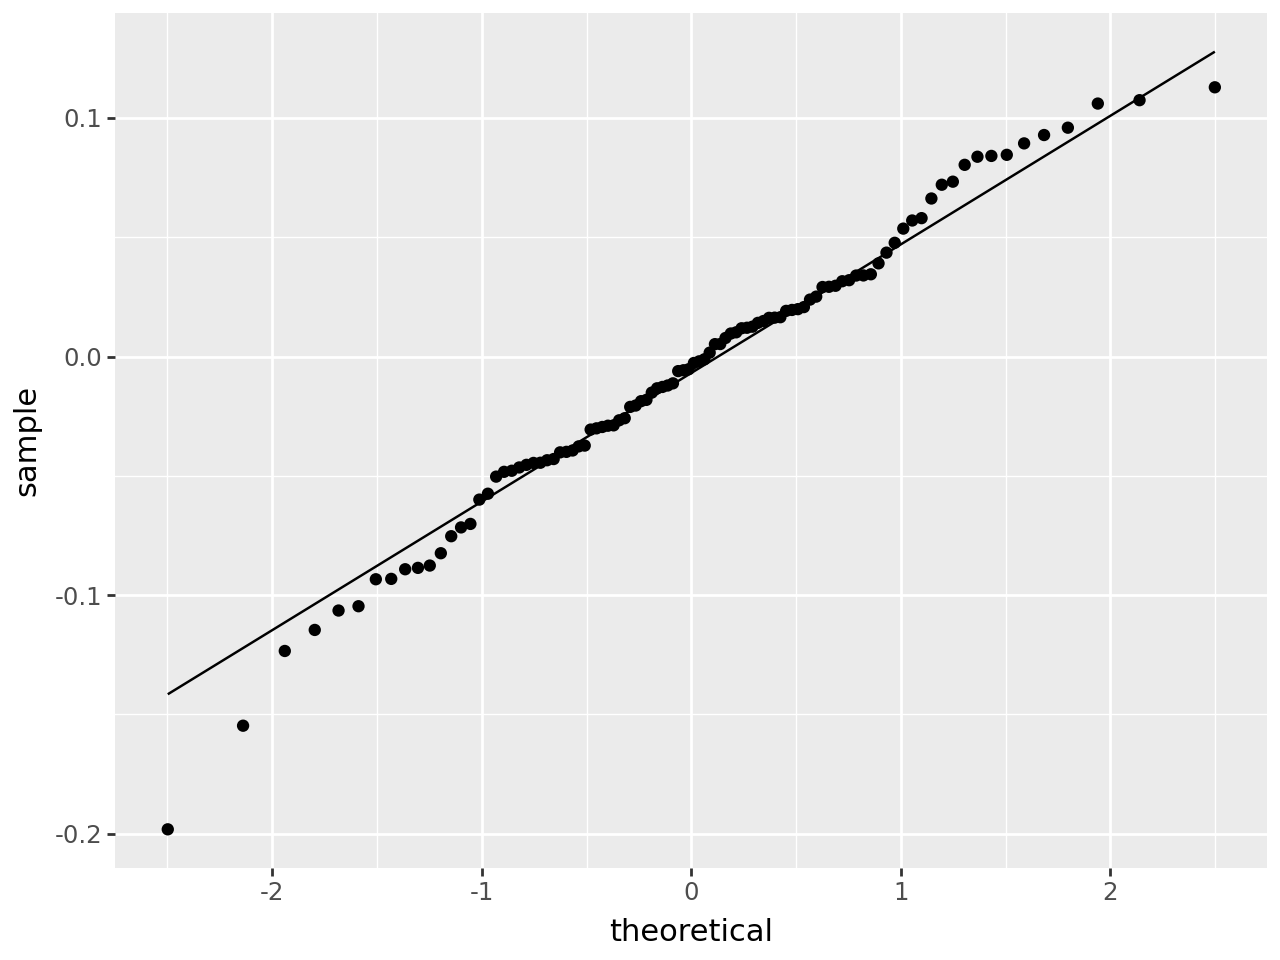

In [229]:
pn.ggplot(pn.aes(sample=coefs)) + pn.stat_qq() + pn.stat_qq_line()

Adipose Tissue
[1] "Running test"


R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced



[1] "Fitting sex model"

Call:
DirichReg(formula = proportion ~ sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.5325  -0.5248  -0.1105   0.4431   5.1258
proportion_ENST00000371584   -1.2341  -0.5499  -0.1282   0.4397   3.5037
proportion_ENST00000371588  -15.9790  -0.3728   0.2414   0.7169   1.8317
proportion_ENST00000413082   -0.5357  -0.5357  -0.5305  -0.5263  58.3511
proportion_ENST00000466152   -1.2639  -0.5716  -0.0691   0.4767   3.7603
proportion_ENST00000494752   -0.5200  -0.5200  -0.5134  -0.5134   4.7854

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.80728    0.05239   15.41  < 2e-16 ***
sexMale     -0.25047    0.07499   -3.34 0.000837 ***
------------------------------------------------------------------
Beta-Coefficients for var

In [336]:
df

,transcript,sample,tissue,sex,proportion,individual
0,ENST00000371582,GTEX-132QS-0826-SM-5K7WV,Adipose Tissue,Male,2.974420e-02,GTEX-132QS
1,ENST00000371582,GTEX-1EN7A-1626-SM-79OLV,Adipose Tissue,Male,2.945937e-02,GTEX-1EN7A
2,ENST00000371582,GTEX-15SKB-1626-SM-6PAL6,Adipose Tissue,Male,2.770013e-02,GTEX-15SKB
3,ENST00000371582,GTEX-1GN2E-0326-SM-COH3C,Adipose Tissue,Male,4.993873e-02,GTEX-1GN2E
4,ENST00000371582,GTEX-1R9PM-2126-SM-E8VOB,Adipose Tissue,Male,4.789322e-02,GTEX-1R9PM
...,...,...,...,...,...,...
40207,ENST00000494752,GTEX-1HBPM-0926-SM-ARL9C,Thyroid,Female,3.707824e-12,GTEX-1HBPM
40208,ENST00000494752,GTEX-11ZVC-0126-SM-5986G,Thyroid,Female,3.092146e-12,GTEX-11ZVC
40209,ENST00000494752,GTEX-1F52S-0526-SM-7P8TP,Thyroid,Female,3.639199e-03,GTEX-1F52S
40210,ENST00000494752,GTEX-WEY5-0526-SM-3GIKZ,Thyroid,Female,2.265006e-12,GTEX-WEY5


In [446]:
# extract relevant data
df = final_xrds['proportion'].to_dataframe().reset_index()[
    ['transcript', 'sample', 'tissue', 'sex', 'proportion', 'individual']]
run_dirichlet_reg(df)

data pivot
[1] "Running test"


R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  not all rows sum up to 1 => normalization forced
  some entries are 0 or 1 => transformation forced



[1] "Fitting null model"
[1] "Fitting sex model"
[1] "Likelihood-ratio test"

Analysis of Deviance Table

Model 1: DirichReg(formula = proportion ~ tissue * sex | tissue, data = df,
  model = "alternative")
Model 2: DirichReg(formula = proportion ~ tissue * sex | tissue + sex, data =
  df, model = "alternative")

        Deviance N. par Difference df  Pr(>Chi)    
Model 1   -12319     60                            
Model 2   -12431     61     111.58  1 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



In [451]:
# extract relevant data
df = final_xrds['proportion'].to_dataframe().reset_index()[
    ['transcript', 'sample', 'tissue', 'sex', 'proportion', 'individual']]
random_individuals_df = df[['individual', 'sex']].drop_duplicates().reset_index(drop=True)
random_individuals_df['sex'] = np.random.permutation(random_individuals_df['sex'].values)
random_individuals_df = random_individuals_df.set_index('individual')
random_df = df.copy()
random_df['sex'] = random_individuals_df.loc[random_df['individual'].values]['sex'].values
run_dirichlet_reg(random_df)

data pivot
[1] "Running test"


R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  not all rows sum up to 1 => normalization forced
  some entries are 0 or 1 => transformation forced



[1] "Fitting null model"
[1] "Fitting sex model"
[1] "Likelihood-ratio test"

Analysis of Deviance Table

Model 1: DirichReg(formula = proportion ~ tissue * sex | tissue, data = df,
  model = "alternative")
Model 2: DirichReg(formula = proportion ~ tissue * sex | tissue + sex, data =
  df, model = "alternative")

        Deviance N. par Difference df Pr(>Chi)  
Model 1   -12338     60                         
Model 2   -12345     61      6.587  1  0.01027 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



In [434]:
ro.r('print(coef(sexModel))')

$beta
$beta$proportion_ENST00000367770
NULL

$beta$proportion_ENST00000367771
                  (Intercept)           tissueAdrenal Gland 
                   0.52344403                    0.38554440 
                  tissueBlood            tissueBlood Vessel 
                   0.19132535                    0.64068672 
                  tissueBrain                  tissueBreast 
                   0.09496630                    0.01225575 
                  tissueColon               tissueEsophagus 
                   0.05759477                    0.22555706 
                  tissueHeart                   tissueLiver 
                  -0.11146369                   -0.24810038 
                   tissueLung                  tissueMuscle 
                   0.24411164                    0.22226283 
                  tissueNerve                tissuePancreas 
                  -0.27096684                   -0.29795945 
              tissuePituitary                    tissueSkin 
       

beta,[19]
gamma,[19]


In [409]:
ro.r('print(summary(sexModel))')


Call:
DirichReg(formula = proportion ~ tissue + sex | tissue + sex, data = df, model
= "alternative")

Standardized Residuals:
                                Min       1Q   Median      3Q     Max
proportion_ENST00000372958  -7.3232  -0.6912  -0.5722  0.6500  1.1032
proportion_ENST00000541991  -1.1032  -0.6500   0.5722  0.6912  7.3232

MEAN MODELS:
------------------------------------------------------------------
Coefficients for variable no. 1: proportion_ENST00000372958
- variable omitted (reference category) -
------------------------------------------------------------------
Coefficients for variable no. 2: proportion_ENST00000541991
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)           -0.919967   0.063220 -14.552  < 2e-16 ***
tissueAdrenal Gland   -0.005427   0.130077  -0.042 0.966723    
tissueBlood            0.091156   0.085933   1.061 0.288790    
tissueBlood Vessel     0.095106   0.086440   1.100 0.271218    
tissueBrain           -1.937598 

<rpy2.rinterface_lib.sexp.NULLType object at 0x7f878e7a1010> [0]

In [410]:
random_individuals_df = df[['individual', 'sex']].drop_duplicates().reset_index(drop=True)
random_individuals_df['sex'] = np.random.permutation(random_individuals_df['sex'].values)
random_individuals_df = random_individuals_df.set_index('individual')
random_df = df.copy()
random_df['sex'] = random_individuals_df.loc[random_df['individual'].values]['sex'].values
run_dirichlet_reg(random_df)

data pivot
[1] "Running test"


R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  some entries are 0 or 1 => transformation forced



[1] "Fitting null model"
[1] "Fitting sex model"
[1] "Likelihood-ratio test"

Analysis of Deviance Table

Model 1: DirichReg(formula = proportion ~ tissue + sex | tissue, data = df,
  model = "alternative")
Model 2: DirichReg(formula = proportion ~ tissue + sex | tissue + sex, data =
  df, model = "alternative")

        Deviance N. par Difference df Pr(>Chi)
Model 1   -23556     41                       
Model 2   -23556     42       0.03  1   0.8626



In [26]:
random_df.drop_duplicates(subset=['sample'])

,transcript,sample,tissue,sex,proportion,individual
524,ENST00000371582,GTEX-1F75A-2026-SM-9KNTR,Adrenal Gland,Male,0.043478,GTEX-1F75A
525,ENST00000371582,GTEX-111CU-0126-SM-5GZWZ,Adrenal Gland,Male,0.021016,GTEX-111CU
526,ENST00000371582,GTEX-1GL5R-1026-SM-7P8U1,Adrenal Gland,Male,0.052660,GTEX-1GL5R
527,ENST00000371582,GTEX-13FTW-0126-SM-5IJED,Adrenal Gland,Male,0.062868,GTEX-13FTW
528,ENST00000371582,GTEX-1399R-0326-SM-5KM1X,Adrenal Gland,Male,0.099548,GTEX-1399R
...,...,...,...,...,...,...
675,ENST00000371582,GTEX-1J8EW-1826-SM-C1YQW,Adrenal Gland,Male,0.030369,GTEX-1J8EW
676,ENST00000371582,GTEX-1AMFI-0626-SM-731DR,Adrenal Gland,Male,0.010857,GTEX-1AMFI
677,ENST00000371582,GTEX-Y5LM-0126-SM-4VBRL,Adrenal Gland,Female,0.052621,GTEX-Y5LM
678,ENST00000371582,GTEX-1IDJU-0126-SM-CNNR2,Adrenal Gland,Female,0.034385,GTEX-1IDJU


In [128]:
np.sum(random_df['sex'] == df['sex'])

np.int64(20694)

In [133]:
ro.r('print(summary(sexModel))')


Call:
DirichReg(formula = proportion ~ tissue * sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.7217  -0.4857  -0.0134   0.5036   6.3361
proportion_ENST00000371584   -1.3870  -0.4275   0.0312   0.5584   5.0908
proportion_ENST00000371588  -14.2388  -0.4395   0.0763   0.5230   1.9515
proportion_ENST00000413082   -0.5259  -0.4283  -0.4237  -0.3956  58.8414
proportion_ENST00000466152   -1.7256  -0.5464  -0.1456   0.3838   8.5071
proportion_ENST00000494752   -0.5265  -0.4384  -0.4273  -0.3082  23.7846

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
                              Estimate Std. Error z value Pr(>|z|)    
(Intercept)                    0.41148    0.05564   7.395 1.41e-13 ***
tissueAdrenal Gland            0.32152    0.11259   2.856 0.004293 ** 
tissueBladder                  0.27555    0.33305   0

<rpy2.rinterface_lib.sexp.NULLType object at 0x7f06f56e7210> [0]

In [62]:
df

,transcript,sample,tissue,sex,proportion,individual
0,ENST00000371582,GTEX-ZEX8-1226-SM-5S2OK,Adipose Tissue,Male,0.046067,GTEX-ZEX8
1,ENST00000371582,GTEX-1F5PK-2526-SM-9MQKN,Adipose Tissue,Male,0.037918,GTEX-1F5PK
2,ENST00000371582,GTEX-1CB4E-0826-SM-793CS,Adipose Tissue,Male,0.082356,GTEX-1CB4E
3,ENST00000371582,GTEX-PLZ6-1326-SM-3NB24,Adipose Tissue,Male,0.058197,GTEX-PLZ6
4,ENST00000371582,GTEX-14ICL-0926-SM-5S2TU,Adipose Tissue,Male,0.040082,GTEX-14ICL
...,...,...,...,...,...,...
42559,ENST00000494752,GTEX-11XUK-0226-SM-5EQLW,Thyroid,Female,0.000000,GTEX-11XUK
42560,ENST00000494752,GTEX-15ETS-0526-SM-6PAN3,Thyroid,Female,0.008236,GTEX-15ETS
42561,ENST00000494752,GTEX-145MI-1126-SM-5O9AK,Thyroid,Female,0.017833,GTEX-145MI
42562,ENST00000494752,GTEX-1HC8U-1226-SM-9WYUW,Thyroid,Female,0.000000,GTEX-1HC8U


In [72]:
random_df.groupby(['individual', 'tissue'])['sample'].count()

individual  tissue        
GTEX-1117F  Adipose Tissue    12
            Blood Vessel      12
            Brain              6
            Breast             6
            Heart              6
                              ..
GTEX-ZZPU   Pancreas           6
            Skin               6
            Spleen             6
            Stomach            6
            Thyroid            6
Name: sample, Length: 10733, dtype: int64

In [70]:
random_df.groupby(['individual'])['sample'].count()

individual
GTEX-1117F     60
GTEX-111CU    102
GTEX-111FC     84
GTEX-111VG     60
GTEX-111YS    138
             ... 
GTEX-ZYW4      96
GTEX-ZYY3      96
GTEX-ZZ64      90
GTEX-ZZPT      42
GTEX-ZZPU     108
Name: sample, Length: 946, dtype: int64

In [122]:
with (ro.default_converter + pandas2ri.converter).context():
    rcoefs = ro.r('lapply(coef(sexModel), function(x) x[["sexMale"]])')
pd.Series({k.split('_')[1] : v[0] for k,v in rcoefs.items()})

ENST00000371582   -0.093032
ENST00000371584   -0.090272
ENST00000371588   -0.040511
ENST00000413082   -0.003925
ENST00000466152    0.018446
ENST00000494752   -0.005953
dtype: float64

In [127]:
ro.r('print(summary(sexModel))')


Call:
DirichReg(formula = proportion ~ tissue + sex, data = df)

Standardized Residuals:
                                 Min       1Q   Median       3Q      Max
proportion_ENST00000371582   -1.7025  -0.4555  -0.0239   0.4714   7.3116
proportion_ENST00000371584   -1.6653  -0.4112   0.0247   0.5345   5.9957
proportion_ENST00000371588  -15.1424  -0.4285   0.0578   0.4869   2.6973
proportion_ENST00000413082   -0.4593  -0.4048  -0.3973  -0.3806  64.8947
proportion_ENST00000466152   -2.4135  -0.5253  -0.1299   0.3745   7.7582
proportion_ENST00000494752   -0.6508  -0.4135  -0.4043  -0.1499  25.5031

------------------------------------------------------------------
Beta-Coefficients for variable no. 1: proportion_ENST00000371582
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)            0.42900    0.02822  15.201  < 2e-16 ***
tissueAdrenal Gland    0.15416    0.06157   2.504 0.012290 *  
tissueBladder          0.33855    0.19173   1.766 0.077429 .  
tissueBlood   

<rpy2.rinterface_lib.sexp.NULLType object at 0x7fa2deadb090> [0]

In [155]:
ro.r('''
saveRDS(DR_data(df[, propColumns]), 'tmp.RDS')
''')

R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  not all rows sum up to 1 => normalization forced
  some entries are 0 or 1 => transformation forced



<rpy2.rinterface_lib.sexp.NULLType object at 0x7fa2deadb090> [0]

In [137]:
str(ro.r('getwd()'))

'[1] "/data/nasif12/home_if12/tsi/projects/kipoi_veff_analysis/notebooks/gtex/sex_analysis"\n'